In [1]:
import sys
import os
import datetime
import warnings
os.environ['OPENBLAS_NUM_THREADS'] = '1'
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import time
import pyarrow.parquet as pq
import pyarrow as pa
import scipy
import implicit
import bisect
import sklearn.metrics as m
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

In [3]:
LOCAL_DATA_PATH = './context_data/'
SPLIT_SEED = 42
DATA_FILE = 'competition_data_final_pqt'
TARGET_FILE = 'public_train.pqt'
SUBMISSION_FILE = 'submit.pqt'

In [4]:
id_to_submit = pq.read_table(f'{LOCAL_DATA_PATH}/{SUBMISSION_FILE}').to_pandas()

In [5]:
# pqf = pq.ParquetFile(f'{LOCAL_DATA_PATH}/{DATA_FILE}')
pqd = pq.ParquetDataset(f'{LOCAL_DATA_PATH}/{DATA_FILE}')
pqd.files

['./context_data//competition_data_final_pqt/part-00000-aba60f69-2b63-4cc1-95ca-542598094698-c000.snappy.parquet',
 './context_data//competition_data_final_pqt/part-00001-aba60f69-2b63-4cc1-95ca-542598094698-c000.snappy.parquet',
 './context_data//competition_data_final_pqt/part-00002-aba60f69-2b63-4cc1-95ca-542598094698-c000.snappy.parquet',
 './context_data//competition_data_final_pqt/part-00003-aba60f69-2b63-4cc1-95ca-542598094698-c000.snappy.parquet',
 './context_data//competition_data_final_pqt/part-00004-aba60f69-2b63-4cc1-95ca-542598094698-c000.snappy.parquet',
 './context_data//competition_data_final_pqt/part-00005-aba60f69-2b63-4cc1-95ca-542598094698-c000.snappy.parquet',
 './context_data//competition_data_final_pqt/part-00006-aba60f69-2b63-4cc1-95ca-542598094698-c000.snappy.parquet',
 './context_data//competition_data_final_pqt/part-00007-aba60f69-2b63-4cc1-95ca-542598094698-c000.snappy.parquet',
 './context_data//competition_data_final_pqt/part-00008-aba60f69-2b63-4cc1-95ca-

In [6]:
data_agg = None
for ifile in pqd.files :

    #data = pq.read_table(f'{LOCAL_DATA_PATH}/{DATA_FILE}/{ifile}')
    data = pq.read_table(f'{ifile}')
    #pd.DataFrame([(z.name, z.type) for z in data.schema], columns = [['field', 'type']])

    data_agg0 = data.select(['user_id', 'url_host', 'request_cnt']).\
        group_by(['user_id', 'url_host']).aggregate([('request_cnt', "sum"),('request_cnt', "mean"),])
    
    data_agg1 = data.select(['user_id','date', 'part_of_day', 'request_cnt']).\
        group_by(['user_id', 'date', 'part_of_day']).aggregate([('request_cnt', "sum")])
    
    data_agg2 = data.select(['user_id', 'city_name', 'region_name', 'cpe_model_os_type', 'price','request_cnt']).\
        group_by(['user_id', ]).\
        aggregate([('cpe_model_os_type', "max"), ('price', "max"), ('city_name', "max"), \
                   ('region_name', "max"),('request_cnt',"mean"),('request_cnt',"sum")])
    
    if data_agg is None :
        data_agg  = data_agg0
        data_aggB = data_agg1
        data_aggZ = data_agg2
        print(data.to_pandas().head())
    else :
        data_agg  = pa.concat_tables([data_agg, data_agg0],promote=False)
        data_aggB = pa.concat_tables([data_aggB,data_agg1],promote=False)
        data_aggZ = pa.concat_tables([data_aggZ,data_agg2],promote=False)
    
    del data, data_agg0, data_agg1, data_agg2
    
data_agg  = data_agg.to_pandas()
data_aggB = data_aggB.to_pandas()
data_aggZ = data_aggZ.to_pandas().fillna(0)

          region_name  city_name cpe_manufacturer_name cpe_model_name  \
0  Краснодарский край  Краснодар                 Apple       iPhone 7   
1  Краснодарский край  Краснодар                 Apple       iPhone 7   
2  Краснодарский край  Краснодар                 Apple       iPhone 7   
3  Краснодарский край  Краснодар                 Apple       iPhone 7   
4  Краснодарский край  Краснодар                 Apple       iPhone 7   

                      url_host cpe_type_cd cpe_model_os_type    price  \
0                ad.adriver.ru  smartphone               iOS  20368.0   
1                    apple.com  smartphone               iOS  20368.0   
2       avatars.mds.yandex.net  smartphone               iOS  20368.0   
3  googleads.g.doubleclick.net  smartphone               iOS  20368.0   
4  googleads.g.doubleclick.net  smartphone               iOS  20368.0   

         date part_of_day  request_cnt  user_id  
0  2022-06-15     morning            1    45098  
1  2022-06-19     morn

Регион   
, населенный пункт   
, производиель устройства   
, модель устроства   
, домен, с которого пришел рекламный запрос   
, тип устройства (смартфон или что-то другое)   
, операционка на устройстве   
, оценка цены устройства   
, дата   
, время дня (утро, вечер ...)   
, число запросов   
, id пользователя   

In [7]:
data_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32277669 entries, 0 to 32277668
Data columns (total 4 columns):
 #   Column            Dtype  
---  ------            -----  
 0   request_cnt_sum   int64  
 1   request_cnt_mean  float64
 2   user_id           int64  
 3   url_host          object 
dtypes: float64(1), int64(2), object(1)
memory usage: 985.0+ MB


In [8]:
data_agg.columns, data_aggB.columns, data_aggZ.columns

(Index(['request_cnt_sum', 'request_cnt_mean', 'user_id', 'url_host'], dtype='object'),
 Index(['request_cnt_sum', 'user_id', 'date', 'part_of_day'], dtype='object'),
 Index(['cpe_model_os_type_max', 'price_max', 'city_name_max',
        'region_name_max', 'request_cnt_mean', 'request_cnt_sum', 'user_id'],
       dtype='object'))

In [9]:
urls_hosts_max=data_agg[['url_host','user_id']].groupby(['url_host']).count().\
                sort_values('user_id', ascending=False)[135000:].reset_index()['url_host']

In [10]:
#data_aggY = data_agg[~data_agg.url_host.isin(urls_hosts_max.to_list())]

In [11]:
len(data_agg), len(data_agg['user_id'].unique())

(32277669, 415317)

In [12]:
if 1 :
    
    data_aggC = data_aggZ[['user_id','price_max']]
    
    data_aggD = pd.pivot_table(data_aggB[['user_id','part_of_day','request_cnt_sum']],
                                index='user_id', columns='part_of_day', values='request_cnt_sum', 
                                aggfunc=np.mean, fill_value=0).reset_index()
    data_aggC = data_aggC.merge(data_aggD,how='inner',on=['user_id'])
    
    data_aggB['DW'] = 'DW' + pd.to_datetime(data_aggB.date).dt.day_of_week.astype(str)
    data_aggD = pd.pivot_table(data_aggB[['user_id','DW','request_cnt_sum']],
                                index='user_id', columns='DW', values='request_cnt_sum', 
                                aggfunc=np.mean, fill_value=0).reset_index()
    data_aggC = data_aggC.merge(data_aggD,how='inner',on=['user_id'])

    data_aggB['DW'] = 'DWPD'+pd.to_datetime(data_aggB.date).dt.day_of_week.astype(str)+'.'+data_aggB.part_of_day
    data_aggD = pd.pivot_table(data_aggB[['user_id','DW','request_cnt_sum']],
                                index='user_id', columns='DW', values='request_cnt_sum', 
                                aggfunc=np.mean, fill_value=0).reset_index()
    data_aggC = data_aggC.merge(data_aggD,how='inner',on=['user_id'])
    
    if 0 :
        data_aggD = pd.get_dummies(data_aggZ.city_name_max,prefix='city')
        data_aggD['user_id'] = data_aggZ.user_id
        data_aggC = data_aggC.merge(data_aggD,how='inner',on=['user_id'])

    if 0 :
        data_aggD = pd.get_dummies(data_aggZ.region_name_max,prefix='region')
        data_aggD['user_id'] = data_aggZ.user_id
        data_aggC = data_aggC.merge(data_aggD,how='inner',on=['user_id'])

    data_aggD = pd.get_dummies(data_aggZ.cpe_model_os_type_max,prefix='os')
    data_aggD['user_id'] = data_aggZ.user_id
    data_aggC = data_aggC.merge(data_aggD,how='inner',on=['user_id'])

In [13]:
data_aggC.shape, data_aggC.columns

((415317, 44),
 Index(['user_id', 'price_max', 'day', 'evening', 'morning', 'night', 'DW0',
        'DW1', 'DW2', 'DW3', 'DW4', 'DW5', 'DW6', 'DWPD0.day', 'DWPD0.evening',
        'DWPD0.morning', 'DWPD0.night', 'DWPD1.day', 'DWPD1.evening',
        'DWPD1.morning', 'DWPD1.night', 'DWPD2.day', 'DWPD2.evening',
        'DWPD2.morning', 'DWPD2.night', 'DWPD3.day', 'DWPD3.evening',
        'DWPD3.morning', 'DWPD3.night', 'DWPD4.day', 'DWPD4.evening',
        'DWPD4.morning', 'DWPD4.night', 'DWPD5.day', 'DWPD5.evening',
        'DWPD5.morning', 'DWPD5.night', 'DWPD6.day', 'DWPD6.evening',
        'DWPD6.morning', 'DWPD6.night', 'os_Android', 'os_Apple iOS', 'os_iOS'],
       dtype='object'))

In [14]:

if 1 :
    data_aggC['A']=data_aggC.day+data_aggC.evening+data_aggC.morning+data_aggC.night
    data_aggC['A000']=data_aggC.day/data_aggC.A
    data_aggC['A001']=data_aggC.evening/data_aggC.A
    data_aggC['A002']=data_aggC.morning/data_aggC.A
    data_aggC['A003']=data_aggC.night/data_aggC.A
    
if 1 :
    B000m=data_aggC.day.mean()
    B001m=data_aggC.evening.mean()
    B002m=data_aggC.morning.mean()
    B003m=data_aggC.night.mean()
    data_aggC['B000']=data_aggC.day/B000m
    data_aggC['B001']=data_aggC.evening/B001m
    data_aggC['B002']=data_aggC.morning/B002m
    data_aggC['B003']=data_aggC.night/B003m
    #data_aggC = data_aggC.drop(['day','morning','evening'],axis=1)
        
if 1 :
    DWA0  =data_aggC.DW0.median()
    DWA1  =data_aggC.DW1.median()
    DWA2  =data_aggC.DW2.median()
    DWA3  =data_aggC.DW3.median()
    DWA4  =data_aggC.DW4.median()
    DWA5  =data_aggC.DW5.median()
    DWA6  =data_aggC.DW6.median()
    data_aggC['DWB000']=data_aggC.DW0/DWA0
    data_aggC['DWB001']=data_aggC.DW1/DWA1
    data_aggC['DWB002']=data_aggC.DW2/DWA2
    data_aggC['DWB003']=data_aggC.DW3/DWA3
    data_aggC['DWB004']=data_aggC.DW4/DWA4
    data_aggC['DWB005']=data_aggC.DW5/DWA5
    data_aggC['DWB006']=data_aggC.DW6/DWA6
    
if 1 :
    data_aggC['DWA']=data_aggC.DW0+data_aggC.DW1+data_aggC.DW2+data_aggC.DW3+ \
                        data_aggC.DW4+data_aggC.DW5+data_aggC.DW6
    data_aggC['DW000']=data_aggC.DW0/data_aggC.DWA
    data_aggC['DW001']=data_aggC.DW1/data_aggC.DWA
    data_aggC['DW002']=data_aggC.DW2/data_aggC.DWA
    data_aggC['DW003']=data_aggC.DW3/data_aggC.DWA
    data_aggC['DW004']=data_aggC.DW4/data_aggC.DWA
    data_aggC['DW005']=data_aggC.DW5/data_aggC.DWA
    data_aggC['DW006']=data_aggC.DW6/data_aggC.DWA
    
data_aggC.shape, data_aggC.columns

((415317, 68),
 Index(['user_id', 'price_max', 'day', 'evening', 'morning', 'night', 'DW0',
        'DW1', 'DW2', 'DW3', 'DW4', 'DW5', 'DW6', 'DWPD0.day', 'DWPD0.evening',
        'DWPD0.morning', 'DWPD0.night', 'DWPD1.day', 'DWPD1.evening',
        'DWPD1.morning', 'DWPD1.night', 'DWPD2.day', 'DWPD2.evening',
        'DWPD2.morning', 'DWPD2.night', 'DWPD3.day', 'DWPD3.evening',
        'DWPD3.morning', 'DWPD3.night', 'DWPD4.day', 'DWPD4.evening',
        'DWPD4.morning', 'DWPD4.night', 'DWPD5.day', 'DWPD5.evening',
        'DWPD5.morning', 'DWPD5.night', 'DWPD6.day', 'DWPD6.evening',
        'DWPD6.morning', 'DWPD6.night', 'os_Android', 'os_Apple iOS', 'os_iOS',
        'A', 'A000', 'A001', 'A002', 'A003', 'B000', 'B001', 'B002', 'B003',
        'DWB000', 'DWB001', 'DWB002', 'DWB003', 'DWB004', 'DWB005', 'DWB006',
        'DWA', 'DW000', 'DW001', 'DW002', 'DW003', 'DW004', 'DW005', 'DW006'],
       dtype='object'))

In [15]:
data_aggC.shape

(415317, 68)

In [16]:
if 0 :
    import matplotlib.pyplot as mp

    mp.hist(data_aggC.day, 100)
    mp.hist(data_aggC.morning, 100)
    mp.hist(data_aggC.evening, 100)
    #mp.hist(data_aggC.A003, 100)
    #mp.hist(data_aggC.DWB004, 100)

    mp.show()

    mp.hist(data_aggC.price_max,100)
    mp.show()

    mp.scatter(data_aggC.night,data_aggC['DWPD0.night'])
    mp.show()

In [17]:
targets = pq.read_table(f'{LOCAL_DATA_PATH}/{TARGET_FILE}')
pd.DataFrame([(z.name, z.type) for z in targets.schema], columns = [['field', 'type']])

,field,type
0,age,double
1,is_male,string
2,user_id,int64
3,__index_level_0__,int64


In [18]:
import faiss

def set1 (items) :
    item_set = set(items)
    #print(f'{len(items)} items')
    item_dict = {item: iditem for item, iditem in zip(item_set, range(len(item_set)))}
    items_new = np.array(items.map(item_dict))
    return(item_dict, items_new)
    
def alsals (values, rows, cols, factors=50, iterations=30, clusters=400) :
    
    #values = np.array(data_agg['request_cnt_sum'])
    #rows   = np.array(data_agg['user_id'].map(usr_dict))
    #cols   = np.array(data_agg['url_host'].map(url_dict))
    mat = scipy.sparse.coo_matrix((values, (rows, cols)), shape=(rows.max() + 1, cols.max() + 1))
    als = implicit.approximate_als.FaissAlternatingLeastSquares(factors = factors, iterations = iterations, \
           use_gpu = False, nlist=clusters, \
           calculate_training_loss = False, regularization = 0.1)
    als.fit(mat)
    u_factors = als.model.user_factors 
    d_factors = als.model.item_factors
    
    return u_factors

def doMatrix (users, items, values, clusters=400, factors=50, iterations=30) :
    users_dict, users_new = set1(users)
    items_dict, items_new = set1(items)

    uu = alsals(values,users_new,items_new, clusters=clusters, factors=factors, iterations=iterations)
    uu = pd.DataFrame(uu)

    inv_users_dict = {v: k for k, v in users_dict.items()}
    uu['user_id'] = uu.index.map(inv_users_dict)
    return uu

In [19]:
%%time

if 0 :
    u3 = doMatrix(data_aggB.user_id, data_aggB.date,         data_aggB.request_cnt_sum, clusters=10, factors=50)
    u0 = doMatrix(data_agg.user_id,  data_agg.url_host,     data_agg.request_cnt_sum, clusters=400, factors=250)

    u1 = doMatrix(data_aggZ.user_id, data_aggZ.region_name_max, data_aggZ.request_cnt_mean, clusters=5)
    u2 = doMatrix(data_aggZ.user_id, data_aggZ.city_name_max,   data_aggZ.request_cnt_mean, clusters=20)

u12= doMatrix(pd.concat([data_aggZ.user_id,data_aggZ.user_id,data_agg.user_id,
                         data_agg.user_id],ignore_index=True),
              pd.concat([data_aggZ.region_name_max,data_aggZ.city_name_max,data_agg.url_host,\
                         data_agg.url_host,],ignore_index=True),\
              pd.concat([data_aggZ.request_cnt_mean,data_aggZ.request_cnt_mean,data_agg.request_cnt_sum,\
                         data_agg.request_cnt_mean,],\
                        ignore_index=True),
              #clusters=400, factors=50)
              clusters=500, factors=50)

  0%|          | 0/30 [00:00<?, ?it/s]

CPU times: user 27min 48s, sys: 4.3 s, total: 27min 53s
Wall time: 3min 55s


In [20]:
u12.shape

(415317, 51)

## Получим оценку по полу

In [35]:
%%time
'''
inv_usr_map = {v: k for k, v in usr_dict.items()}
usr_emb = pd.DataFrame(u_factors)
usr_emb['user_id'] = usr_emb.index.map(inv_usr_map)
'''

usr_emb = u12
'''
print(len(u1),len(u0),len(usr_emb))
usr_emb = usr_emb.merge(u0, how = 'inner', on = ['user_id'], suffixes=('_u0', '_u1') )
usr_emb = usr_emb.merge(u1, how = 'inner', on = ['user_id'], suffixes=('_u0', '_u1') )
usr_emb = usr_emb.merge(u2, how = 'inner', on = ['user_id'], suffixes=('_u12','_u2') )
#usr_emb = usr_emb.merge(u3, how = 'inner', on = ['user_id'], suffixes=('_u23','_u3') )

#usr_emb = usr_emb.merge(u12, how = 'inner', on = ['user_id'], suffixes=('_u20','_u21') )

#usr_emb = usr_emb.fillna(-1)
'''
#usr_emb = usr_emb.fillna(-1)

usr_emb = usr_emb.merge(data_aggC, how = 'inner', on = ['user_id'], suffixes=('_u12','_aggC'))
usr_targets = targets.to_pandas()
df = usr_targets.merge(usr_emb,   how = 'inner', on = ['user_id'])
df = df[df['is_male'] != 'NA']
df = df.dropna()
df['is_male'] = df['is_male'].map(int)
df['is_male'].value_counts()

CPU times: user 1.51 s, sys: 372 ms, total: 1.88 s
Wall time: 1.87 s


1    135331
0    128994
Name: is_male, dtype: int64

In [36]:
#u0[u0.isna()==True].shape, len(u0)
#usr_emb[usr_emb[['0_u0']].isna()]

In [37]:
#df1 = df
#df = df.drop('price_max',axis=1)
df.shape

(264325, 120)

In [38]:
df.shape #, df.columns[:100]

(264325, 120)

In [60]:
%%time
print(datetime.datetime.now())
x_train, x_test, y_train, y_test = train_test_split(\
    df.drop(['user_id', 'age', 'is_male'], axis = 1), df['is_male'], test_size = 0.33, random_state = SPLIT_SEED)

clf = CatBoostClassifier(iterations=5000, early_stopping_rounds=100)

clf.fit(x_train, y_train, verbose = True, eval_set=(x_test,y_test), use_best_model=True)
print(f'GINI по полу {2 * m.roc_auc_score(y_test, clf.predict_proba(x_test)[:,1]) - 1:2.3f}')

2023-02-24 19:39:16.624583
Learning rate set to 0.056515
0:	learn: 0.6885116	test: 0.6886331	best: 0.6886331 (0)	total: 120ms	remaining: 10m 1s
1:	learn: 0.6844043	test: 0.6846184	best: 0.6846184 (1)	total: 170ms	remaining: 7m 3s
2:	learn: 0.6806872	test: 0.6809709	best: 0.6809709 (2)	total: 221ms	remaining: 6m 8s
3:	learn: 0.6774580	test: 0.6777839	best: 0.6777839 (3)	total: 276ms	remaining: 5m 44s
4:	learn: 0.6742849	test: 0.6747941	best: 0.6747941 (4)	total: 313ms	remaining: 5m 13s
5:	learn: 0.6714066	test: 0.6719771	best: 0.6719771 (5)	total: 350ms	remaining: 4m 51s
6:	learn: 0.6686101	test: 0.6692577	best: 0.6692577 (6)	total: 394ms	remaining: 4m 40s
7:	learn: 0.6660444	test: 0.6667409	best: 0.6667409 (7)	total: 434ms	remaining: 4m 30s
8:	learn: 0.6638498	test: 0.6645325	best: 0.6645325 (8)	total: 470ms	remaining: 4m 20s
9:	learn: 0.6614782	test: 0.6622522	best: 0.6622522 (9)	total: 510ms	remaining: 4m 14s
10:	learn: 0.6592319	test: 0.6600094	best: 0.6600094 (10)	total: 546ms	rema

96:	learn: 0.5739353	test: 0.5773796	best: 0.5773796 (96)	total: 3.88s	remaining: 3m 16s
97:	learn: 0.5734323	test: 0.5769160	best: 0.5769160 (97)	total: 3.92s	remaining: 3m 16s
98:	learn: 0.5729569	test: 0.5764475	best: 0.5764475 (98)	total: 3.96s	remaining: 3m 16s
99:	learn: 0.5724834	test: 0.5759869	best: 0.5759869 (99)	total: 4s	remaining: 3m 15s
100:	learn: 0.5720661	test: 0.5755988	best: 0.5755988 (100)	total: 4.04s	remaining: 3m 15s
101:	learn: 0.5715377	test: 0.5751336	best: 0.5751336 (101)	total: 4.07s	remaining: 3m 15s
102:	learn: 0.5710700	test: 0.5747031	best: 0.5747031 (102)	total: 4.11s	remaining: 3m 15s
103:	learn: 0.5705630	test: 0.5742315	best: 0.5742315 (103)	total: 4.15s	remaining: 3m 15s
104:	learn: 0.5701071	test: 0.5738257	best: 0.5738257 (104)	total: 4.19s	remaining: 3m 15s
105:	learn: 0.5696766	test: 0.5734345	best: 0.5734345 (105)	total: 4.23s	remaining: 3m 15s
106:	learn: 0.5692866	test: 0.5730688	best: 0.5730688 (106)	total: 4.26s	remaining: 3m 15s
107:	learn

192:	learn: 0.5408062	test: 0.5470951	best: 0.5470951 (192)	total: 7.59s	remaining: 3m 9s
193:	learn: 0.5405849	test: 0.5468942	best: 0.5468942 (193)	total: 7.64s	remaining: 3m 9s
194:	learn: 0.5403303	test: 0.5466890	best: 0.5466890 (194)	total: 7.68s	remaining: 3m 9s
195:	learn: 0.5400810	test: 0.5464753	best: 0.5464753 (195)	total: 7.72s	remaining: 3m 9s
196:	learn: 0.5398282	test: 0.5462448	best: 0.5462448 (196)	total: 7.76s	remaining: 3m 9s
197:	learn: 0.5395543	test: 0.5459927	best: 0.5459927 (197)	total: 7.83s	remaining: 3m 9s
198:	learn: 0.5393024	test: 0.5457709	best: 0.5457709 (198)	total: 7.88s	remaining: 3m 10s
199:	learn: 0.5390748	test: 0.5455619	best: 0.5455619 (199)	total: 7.93s	remaining: 3m 10s
200:	learn: 0.5388460	test: 0.5453698	best: 0.5453698 (200)	total: 7.99s	remaining: 3m 10s
201:	learn: 0.5386261	test: 0.5451673	best: 0.5451673 (201)	total: 8.04s	remaining: 3m 11s
202:	learn: 0.5383864	test: 0.5449742	best: 0.5449742 (202)	total: 8.09s	remaining: 3m 11s
203:	

284:	learn: 0.5217543	test: 0.5309053	best: 0.5309053 (284)	total: 11.7s	remaining: 3m 13s
285:	learn: 0.5215931	test: 0.5307610	best: 0.5307610 (285)	total: 11.7s	remaining: 3m 13s
286:	learn: 0.5214435	test: 0.5306426	best: 0.5306426 (286)	total: 11.8s	remaining: 3m 13s
287:	learn: 0.5212766	test: 0.5305122	best: 0.5305122 (287)	total: 11.8s	remaining: 3m 13s
288:	learn: 0.5211135	test: 0.5303851	best: 0.5303851 (288)	total: 11.8s	remaining: 3m 12s
289:	learn: 0.5209557	test: 0.5302475	best: 0.5302475 (289)	total: 11.9s	remaining: 3m 12s
290:	learn: 0.5207853	test: 0.5301011	best: 0.5301011 (290)	total: 11.9s	remaining: 3m 12s
291:	learn: 0.5206371	test: 0.5299858	best: 0.5299858 (291)	total: 11.9s	remaining: 3m 12s
292:	learn: 0.5204981	test: 0.5298870	best: 0.5298870 (292)	total: 12s	remaining: 3m 12s
293:	learn: 0.5203305	test: 0.5297490	best: 0.5297490 (293)	total: 12s	remaining: 3m 12s
294:	learn: 0.5201634	test: 0.5295936	best: 0.5295936 (294)	total: 12.1s	remaining: 3m 12s
295

380:	learn: 0.5086569	test: 0.5209502	best: 0.5209502 (380)	total: 15.3s	remaining: 3m 5s
381:	learn: 0.5085417	test: 0.5208609	best: 0.5208609 (381)	total: 15.3s	remaining: 3m 5s
382:	learn: 0.5084322	test: 0.5207896	best: 0.5207896 (382)	total: 15.4s	remaining: 3m 5s
383:	learn: 0.5083170	test: 0.5207167	best: 0.5207167 (383)	total: 15.4s	remaining: 3m 5s
384:	learn: 0.5081947	test: 0.5206312	best: 0.5206312 (384)	total: 15.5s	remaining: 3m 5s
385:	learn: 0.5080887	test: 0.5205663	best: 0.5205663 (385)	total: 15.5s	remaining: 3m 5s
386:	learn: 0.5079601	test: 0.5204864	best: 0.5204864 (386)	total: 15.5s	remaining: 3m 5s
387:	learn: 0.5078481	test: 0.5203978	best: 0.5203978 (387)	total: 15.6s	remaining: 3m 5s
388:	learn: 0.5077333	test: 0.5203262	best: 0.5203262 (388)	total: 15.6s	remaining: 3m 4s
389:	learn: 0.5076301	test: 0.5202490	best: 0.5202490 (389)	total: 15.6s	remaining: 3m 4s
390:	learn: 0.5075046	test: 0.5201512	best: 0.5201512 (390)	total: 15.7s	remaining: 3m 4s
391:	learn

476:	learn: 0.4989483	test: 0.5144266	best: 0.5144266 (476)	total: 18.9s	remaining: 2m 59s
477:	learn: 0.4988541	test: 0.5143625	best: 0.5143625 (477)	total: 19s	remaining: 2m 59s
478:	learn: 0.4987753	test: 0.5143193	best: 0.5143193 (478)	total: 19s	remaining: 2m 59s
479:	learn: 0.4986850	test: 0.5142637	best: 0.5142637 (479)	total: 19s	remaining: 2m 59s
480:	learn: 0.4986059	test: 0.5142126	best: 0.5142126 (480)	total: 19.1s	remaining: 2m 59s
481:	learn: 0.4985090	test: 0.5141682	best: 0.5141682 (481)	total: 19.1s	remaining: 2m 59s
482:	learn: 0.4984171	test: 0.5141065	best: 0.5141065 (482)	total: 19.2s	remaining: 2m 59s
483:	learn: 0.4983342	test: 0.5140677	best: 0.5140677 (483)	total: 19.2s	remaining: 2m 59s
484:	learn: 0.4982413	test: 0.5140111	best: 0.5140111 (484)	total: 19.2s	remaining: 2m 59s
485:	learn: 0.4981384	test: 0.5139469	best: 0.5139469 (485)	total: 19.3s	remaining: 2m 58s
486:	learn: 0.4980534	test: 0.5138985	best: 0.5138985 (486)	total: 19.3s	remaining: 2m 58s
487:	

567:	learn: 0.4916714	test: 0.5101793	best: 0.5101793 (567)	total: 22.5s	remaining: 2m 55s
568:	learn: 0.4915928	test: 0.5101266	best: 0.5101266 (568)	total: 22.5s	remaining: 2m 55s
569:	learn: 0.4915192	test: 0.5100957	best: 0.5100957 (569)	total: 22.6s	remaining: 2m 55s
570:	learn: 0.4914313	test: 0.5100663	best: 0.5100663 (570)	total: 22.6s	remaining: 2m 55s
571:	learn: 0.4913569	test: 0.5100186	best: 0.5100186 (571)	total: 22.7s	remaining: 2m 55s
572:	learn: 0.4912943	test: 0.5099842	best: 0.5099842 (572)	total: 22.7s	remaining: 2m 55s
573:	learn: 0.4912123	test: 0.5099477	best: 0.5099477 (573)	total: 22.8s	remaining: 2m 55s
574:	learn: 0.4911362	test: 0.5098942	best: 0.5098942 (574)	total: 22.8s	remaining: 2m 55s
575:	learn: 0.4910739	test: 0.5098743	best: 0.5098743 (575)	total: 22.8s	remaining: 2m 55s
576:	learn: 0.4910126	test: 0.5098501	best: 0.5098501 (576)	total: 22.9s	remaining: 2m 55s
577:	learn: 0.4909494	test: 0.5098146	best: 0.5098146 (577)	total: 22.9s	remaining: 2m 55s

659:	learn: 0.4854179	test: 0.5070025	best: 0.5070025 (659)	total: 26.7s	remaining: 2m 55s
660:	learn: 0.4853567	test: 0.5069708	best: 0.5069708 (660)	total: 26.8s	remaining: 2m 55s
661:	learn: 0.4852918	test: 0.5069538	best: 0.5069538 (661)	total: 26.8s	remaining: 2m 55s
662:	learn: 0.4852187	test: 0.5069281	best: 0.5069281 (662)	total: 26.9s	remaining: 2m 55s
663:	learn: 0.4851567	test: 0.5069063	best: 0.5069063 (663)	total: 26.9s	remaining: 2m 55s
664:	learn: 0.4850875	test: 0.5068621	best: 0.5068621 (664)	total: 26.9s	remaining: 2m 55s
665:	learn: 0.4850259	test: 0.5068238	best: 0.5068238 (665)	total: 27s	remaining: 2m 55s
666:	learn: 0.4849620	test: 0.5067863	best: 0.5067863 (666)	total: 27s	remaining: 2m 55s
667:	learn: 0.4849072	test: 0.5067648	best: 0.5067648 (667)	total: 27s	remaining: 2m 55s
668:	learn: 0.4848462	test: 0.5067241	best: 0.5067241 (668)	total: 27.1s	remaining: 2m 55s
669:	learn: 0.4847931	test: 0.5067019	best: 0.5067019 (669)	total: 27.1s	remaining: 2m 55s
670:	

753:	learn: 0.4797849	test: 0.5044981	best: 0.5044981 (753)	total: 30.5s	remaining: 2m 51s
754:	learn: 0.4797330	test: 0.5044776	best: 0.5044776 (754)	total: 30.5s	remaining: 2m 51s
755:	learn: 0.4796724	test: 0.5044472	best: 0.5044472 (755)	total: 30.6s	remaining: 2m 51s
756:	learn: 0.4796205	test: 0.5044238	best: 0.5044238 (756)	total: 30.6s	remaining: 2m 51s
757:	learn: 0.4795555	test: 0.5043986	best: 0.5043986 (757)	total: 30.7s	remaining: 2m 51s
758:	learn: 0.4794966	test: 0.5043710	best: 0.5043710 (758)	total: 30.7s	remaining: 2m 51s
759:	learn: 0.4794440	test: 0.5043547	best: 0.5043547 (759)	total: 30.7s	remaining: 2m 51s
760:	learn: 0.4793786	test: 0.5043197	best: 0.5043197 (760)	total: 30.8s	remaining: 2m 51s
761:	learn: 0.4793221	test: 0.5043029	best: 0.5043029 (761)	total: 30.8s	remaining: 2m 51s
762:	learn: 0.4792600	test: 0.5042685	best: 0.5042685 (762)	total: 30.9s	remaining: 2m 51s
763:	learn: 0.4792052	test: 0.5042428	best: 0.5042428 (763)	total: 30.9s	remaining: 2m 51s

846:	learn: 0.4747134	test: 0.5025429	best: 0.5025429 (846)	total: 34.1s	remaining: 2m 47s
847:	learn: 0.4746630	test: 0.5025287	best: 0.5025287 (847)	total: 34.1s	remaining: 2m 47s
848:	learn: 0.4745943	test: 0.5024896	best: 0.5024896 (848)	total: 34.2s	remaining: 2m 47s
849:	learn: 0.4745429	test: 0.5024677	best: 0.5024677 (849)	total: 34.2s	remaining: 2m 47s
850:	learn: 0.4744893	test: 0.5024380	best: 0.5024380 (850)	total: 34.3s	remaining: 2m 47s
851:	learn: 0.4744334	test: 0.5024167	best: 0.5024167 (851)	total: 34.3s	remaining: 2m 46s
852:	learn: 0.4743922	test: 0.5023993	best: 0.5023993 (852)	total: 34.3s	remaining: 2m 46s
853:	learn: 0.4743439	test: 0.5023866	best: 0.5023866 (853)	total: 34.4s	remaining: 2m 46s
854:	learn: 0.4742972	test: 0.5023691	best: 0.5023691 (854)	total: 34.4s	remaining: 2m 46s
855:	learn: 0.4742516	test: 0.5023506	best: 0.5023506 (855)	total: 34.4s	remaining: 2m 46s
856:	learn: 0.4741958	test: 0.5023293	best: 0.5023293 (856)	total: 34.5s	remaining: 2m 46s

942:	learn: 0.4698490	test: 0.5010036	best: 0.5010036 (942)	total: 37.8s	remaining: 2m 42s
943:	learn: 0.4698015	test: 0.5009864	best: 0.5009864 (943)	total: 37.8s	remaining: 2m 42s
944:	learn: 0.4697516	test: 0.5009689	best: 0.5009689 (944)	total: 37.8s	remaining: 2m 42s
945:	learn: 0.4697121	test: 0.5009642	best: 0.5009642 (945)	total: 37.9s	remaining: 2m 42s
946:	learn: 0.4696616	test: 0.5009435	best: 0.5009435 (946)	total: 37.9s	remaining: 2m 42s
947:	learn: 0.4696082	test: 0.5009304	best: 0.5009304 (947)	total: 38s	remaining: 2m 42s
948:	learn: 0.4695578	test: 0.5009151	best: 0.5009151 (948)	total: 38s	remaining: 2m 42s
949:	learn: 0.4695063	test: 0.5009029	best: 0.5009029 (949)	total: 38s	remaining: 2m 42s
950:	learn: 0.4694633	test: 0.5008932	best: 0.5008932 (950)	total: 38.1s	remaining: 2m 42s
951:	learn: 0.4694051	test: 0.5008755	best: 0.5008755 (951)	total: 38.1s	remaining: 2m 42s
952:	learn: 0.4693554	test: 0.5008658	best: 0.5008658 (952)	total: 38.1s	remaining: 2m 41s
953:	

1033:	learn: 0.4655319	test: 0.4997177	best: 0.4997177 (1033)	total: 41.7s	remaining: 2m 39s
1034:	learn: 0.4654857	test: 0.4996995	best: 0.4996995 (1034)	total: 41.7s	remaining: 2m 39s
1035:	learn: 0.4654292	test: 0.4996822	best: 0.4996822 (1035)	total: 41.8s	remaining: 2m 39s
1036:	learn: 0.4653864	test: 0.4996676	best: 0.4996676 (1036)	total: 41.8s	remaining: 2m 39s
1037:	learn: 0.4653380	test: 0.4996528	best: 0.4996528 (1037)	total: 41.9s	remaining: 2m 39s
1038:	learn: 0.4652909	test: 0.4996323	best: 0.4996323 (1038)	total: 41.9s	remaining: 2m 39s
1039:	learn: 0.4652496	test: 0.4996251	best: 0.4996251 (1039)	total: 42s	remaining: 2m 39s
1040:	learn: 0.4652032	test: 0.4996169	best: 0.4996169 (1040)	total: 42s	remaining: 2m 39s
1041:	learn: 0.4651573	test: 0.4996063	best: 0.4996063 (1041)	total: 42s	remaining: 2m 39s
1042:	learn: 0.4651098	test: 0.4995898	best: 0.4995898 (1042)	total: 42.1s	remaining: 2m 39s
1043:	learn: 0.4650652	test: 0.4995833	best: 0.4995833 (1043)	total: 42.1s	r

1123:	learn: 0.4614453	test: 0.4986067	best: 0.4986067 (1123)	total: 45.4s	remaining: 2m 36s
1124:	learn: 0.4613995	test: 0.4986014	best: 0.4986014 (1124)	total: 45.4s	remaining: 2m 36s
1125:	learn: 0.4613580	test: 0.4985917	best: 0.4985917 (1125)	total: 45.5s	remaining: 2m 36s
1126:	learn: 0.4613095	test: 0.4985826	best: 0.4985826 (1126)	total: 45.5s	remaining: 2m 36s
1127:	learn: 0.4612646	test: 0.4985682	best: 0.4985682 (1127)	total: 45.6s	remaining: 2m 36s
1128:	learn: 0.4612347	test: 0.4985548	best: 0.4985548 (1128)	total: 45.6s	remaining: 2m 36s
1129:	learn: 0.4612000	test: 0.4985417	best: 0.4985417 (1129)	total: 45.7s	remaining: 2m 36s
1130:	learn: 0.4611550	test: 0.4985237	best: 0.4985237 (1130)	total: 45.7s	remaining: 2m 36s
1131:	learn: 0.4611119	test: 0.4985168	best: 0.4985168 (1131)	total: 45.7s	remaining: 2m 36s
1132:	learn: 0.4610638	test: 0.4985102	best: 0.4985102 (1132)	total: 45.8s	remaining: 2m 36s
1133:	learn: 0.4610231	test: 0.4985048	best: 0.4985048 (1133)	total: 4

1212:	learn: 0.4575975	test: 0.4978237	best: 0.4978237 (1212)	total: 49s	remaining: 2m 32s
1213:	learn: 0.4575552	test: 0.4978144	best: 0.4978144 (1213)	total: 49s	remaining: 2m 32s
1214:	learn: 0.4575157	test: 0.4978058	best: 0.4978058 (1214)	total: 49s	remaining: 2m 32s
1215:	learn: 0.4574841	test: 0.4977998	best: 0.4977998 (1215)	total: 49.1s	remaining: 2m 32s
1216:	learn: 0.4574471	test: 0.4978066	best: 0.4977998 (1215)	total: 49.1s	remaining: 2m 32s
1217:	learn: 0.4574035	test: 0.4977919	best: 0.4977919 (1217)	total: 49.1s	remaining: 2m 32s
1218:	learn: 0.4573566	test: 0.4977740	best: 0.4977740 (1218)	total: 49.2s	remaining: 2m 32s
1219:	learn: 0.4573164	test: 0.4977755	best: 0.4977740 (1218)	total: 49.2s	remaining: 2m 32s
1220:	learn: 0.4572790	test: 0.4977591	best: 0.4977591 (1220)	total: 49.3s	remaining: 2m 32s
1221:	learn: 0.4572374	test: 0.4977545	best: 0.4977545 (1221)	total: 49.3s	remaining: 2m 32s
1222:	learn: 0.4571922	test: 0.4977415	best: 0.4977415 (1222)	total: 49.3s	r

1302:	learn: 0.4538672	test: 0.4969338	best: 0.4969338 (1302)	total: 52.4s	remaining: 2m 28s
1303:	learn: 0.4538202	test: 0.4969356	best: 0.4969338 (1302)	total: 52.4s	remaining: 2m 28s
1304:	learn: 0.4537858	test: 0.4969281	best: 0.4969281 (1304)	total: 52.5s	remaining: 2m 28s
1305:	learn: 0.4537443	test: 0.4969277	best: 0.4969277 (1305)	total: 52.5s	remaining: 2m 28s
1306:	learn: 0.4537073	test: 0.4969117	best: 0.4969117 (1306)	total: 52.5s	remaining: 2m 28s
1307:	learn: 0.4536722	test: 0.4969084	best: 0.4969084 (1307)	total: 52.6s	remaining: 2m 28s
1308:	learn: 0.4536392	test: 0.4969047	best: 0.4969047 (1308)	total: 52.6s	remaining: 2m 28s
1309:	learn: 0.4536056	test: 0.4968961	best: 0.4968961 (1309)	total: 52.7s	remaining: 2m 28s
1310:	learn: 0.4535559	test: 0.4968789	best: 0.4968789 (1310)	total: 52.7s	remaining: 2m 28s
1311:	learn: 0.4535156	test: 0.4968662	best: 0.4968662 (1311)	total: 52.7s	remaining: 2m 28s
1312:	learn: 0.4534772	test: 0.4968566	best: 0.4968566 (1312)	total: 5

1393:	learn: 0.4503254	test: 0.4963556	best: 0.4963556 (1393)	total: 56.1s	remaining: 2m 25s
1394:	learn: 0.4502910	test: 0.4963520	best: 0.4963520 (1394)	total: 56.1s	remaining: 2m 25s
1395:	learn: 0.4502536	test: 0.4963498	best: 0.4963498 (1395)	total: 56.2s	remaining: 2m 24s
1396:	learn: 0.4502125	test: 0.4963304	best: 0.4963304 (1396)	total: 56.2s	remaining: 2m 25s
1397:	learn: 0.4501788	test: 0.4963255	best: 0.4963255 (1397)	total: 56.3s	remaining: 2m 24s
1398:	learn: 0.4501369	test: 0.4963228	best: 0.4963228 (1398)	total: 56.3s	remaining: 2m 25s
1399:	learn: 0.4500978	test: 0.4963182	best: 0.4963182 (1399)	total: 56.4s	remaining: 2m 24s
1400:	learn: 0.4500577	test: 0.4963081	best: 0.4963081 (1400)	total: 56.4s	remaining: 2m 24s
1401:	learn: 0.4500112	test: 0.4963061	best: 0.4963061 (1401)	total: 56.5s	remaining: 2m 24s
1402:	learn: 0.4499805	test: 0.4963027	best: 0.4963027 (1402)	total: 56.5s	remaining: 2m 24s
1403:	learn: 0.4499481	test: 0.4963040	best: 0.4963027 (1402)	total: 5

1487:	learn: 0.4467441	test: 0.4957816	best: 0.4957816 (1487)	total: 1m	remaining: 2m 22s
1488:	learn: 0.4467005	test: 0.4957714	best: 0.4957714 (1488)	total: 1m	remaining: 2m 22s
1489:	learn: 0.4466623	test: 0.4957608	best: 0.4957608 (1489)	total: 1m	remaining: 2m 22s
1490:	learn: 0.4466275	test: 0.4957738	best: 0.4957608 (1489)	total: 1m	remaining: 2m 21s
1491:	learn: 0.4465881	test: 0.4957738	best: 0.4957608 (1489)	total: 1m	remaining: 2m 21s
1492:	learn: 0.4465558	test: 0.4957735	best: 0.4957608 (1489)	total: 1m	remaining: 2m 21s
1493:	learn: 0.4465213	test: 0.4957682	best: 0.4957608 (1489)	total: 1m	remaining: 2m 21s
1494:	learn: 0.4464849	test: 0.4957631	best: 0.4957608 (1489)	total: 1m	remaining: 2m 21s
1495:	learn: 0.4464474	test: 0.4957516	best: 0.4957516 (1495)	total: 1m	remaining: 2m 21s
1496:	learn: 0.4464088	test: 0.4957409	best: 0.4957409 (1496)	total: 1m	remaining: 2m 21s
1497:	learn: 0.4463789	test: 0.4957328	best: 0.4957328 (1497)	total: 1m	remaining: 2m 21s
1498:	lear

1581:	learn: 0.4432613	test: 0.4952755	best: 0.4952755 (1581)	total: 1m 3s	remaining: 2m 18s
1582:	learn: 0.4432236	test: 0.4952659	best: 0.4952659 (1582)	total: 1m 4s	remaining: 2m 18s
1583:	learn: 0.4431865	test: 0.4952527	best: 0.4952527 (1583)	total: 1m 4s	remaining: 2m 18s
1584:	learn: 0.4431565	test: 0.4952502	best: 0.4952502 (1584)	total: 1m 4s	remaining: 2m 18s
1585:	learn: 0.4431164	test: 0.4952332	best: 0.4952332 (1585)	total: 1m 4s	remaining: 2m 18s
1586:	learn: 0.4430914	test: 0.4952277	best: 0.4952277 (1586)	total: 1m 4s	remaining: 2m 18s
1587:	learn: 0.4430504	test: 0.4952233	best: 0.4952233 (1587)	total: 1m 4s	remaining: 2m 17s
1588:	learn: 0.4430133	test: 0.4952203	best: 0.4952203 (1588)	total: 1m 4s	remaining: 2m 17s
1589:	learn: 0.4429747	test: 0.4952109	best: 0.4952109 (1589)	total: 1m 4s	remaining: 2m 17s
1590:	learn: 0.4429381	test: 0.4952198	best: 0.4952109 (1589)	total: 1m 4s	remaining: 2m 17s
1591:	learn: 0.4428994	test: 0.4952124	best: 0.4952109 (1589)	total: 1

1671:	learn: 0.4399938	test: 0.4948194	best: 0.4948184 (1667)	total: 1m 7s	remaining: 2m 14s
1672:	learn: 0.4399542	test: 0.4948154	best: 0.4948154 (1672)	total: 1m 7s	remaining: 2m 14s
1673:	learn: 0.4399200	test: 0.4948155	best: 0.4948154 (1672)	total: 1m 7s	remaining: 2m 14s
1674:	learn: 0.4398878	test: 0.4948119	best: 0.4948119 (1674)	total: 1m 7s	remaining: 2m 14s
1675:	learn: 0.4398523	test: 0.4948116	best: 0.4948116 (1675)	total: 1m 7s	remaining: 2m 13s
1676:	learn: 0.4398122	test: 0.4948148	best: 0.4948116 (1675)	total: 1m 7s	remaining: 2m 13s
1677:	learn: 0.4397803	test: 0.4948042	best: 0.4948042 (1677)	total: 1m 7s	remaining: 2m 13s
1678:	learn: 0.4397433	test: 0.4947952	best: 0.4947952 (1678)	total: 1m 7s	remaining: 2m 13s
1679:	learn: 0.4397042	test: 0.4947907	best: 0.4947907 (1679)	total: 1m 7s	remaining: 2m 13s
1680:	learn: 0.4396582	test: 0.4947839	best: 0.4947839 (1680)	total: 1m 7s	remaining: 2m 13s
1681:	learn: 0.4396280	test: 0.4947826	best: 0.4947826 (1681)	total: 1

1761:	learn: 0.4368167	test: 0.4944645	best: 0.4944618 (1754)	total: 1m 10s	remaining: 2m 10s
1762:	learn: 0.4367805	test: 0.4944576	best: 0.4944576 (1762)	total: 1m 10s	remaining: 2m 10s
1763:	learn: 0.4367396	test: 0.4944548	best: 0.4944548 (1763)	total: 1m 10s	remaining: 2m 10s
1764:	learn: 0.4367113	test: 0.4944529	best: 0.4944529 (1764)	total: 1m 10s	remaining: 2m 10s
1765:	learn: 0.4366674	test: 0.4944467	best: 0.4944467 (1765)	total: 1m 11s	remaining: 2m 10s
1766:	learn: 0.4366352	test: 0.4944576	best: 0.4944467 (1765)	total: 1m 11s	remaining: 2m 10s
1767:	learn: 0.4366022	test: 0.4944506	best: 0.4944467 (1765)	total: 1m 11s	remaining: 2m 9s
1768:	learn: 0.4365642	test: 0.4944427	best: 0.4944427 (1768)	total: 1m 11s	remaining: 2m 9s
1769:	learn: 0.4365297	test: 0.4944367	best: 0.4944367 (1769)	total: 1m 11s	remaining: 2m 9s
1770:	learn: 0.4364931	test: 0.4944283	best: 0.4944283 (1770)	total: 1m 11s	remaining: 2m 9s
1771:	learn: 0.4364559	test: 0.4944174	best: 0.4944174 (1771)	to

1851:	learn: 0.4337217	test: 0.4941116	best: 0.4941116 (1851)	total: 1m 14s	remaining: 2m 6s
1852:	learn: 0.4336860	test: 0.4941083	best: 0.4941083 (1852)	total: 1m 14s	remaining: 2m 6s
1853:	learn: 0.4336489	test: 0.4941006	best: 0.4941006 (1853)	total: 1m 14s	remaining: 2m 6s
1854:	learn: 0.4336109	test: 0.4940994	best: 0.4940994 (1854)	total: 1m 14s	remaining: 2m 6s
1855:	learn: 0.4335698	test: 0.4940974	best: 0.4940974 (1855)	total: 1m 14s	remaining: 2m 6s
1856:	learn: 0.4335374	test: 0.4940940	best: 0.4940940 (1856)	total: 1m 14s	remaining: 2m 6s
1857:	learn: 0.4335004	test: 0.4940975	best: 0.4940940 (1856)	total: 1m 14s	remaining: 2m 6s
1858:	learn: 0.4334627	test: 0.4941074	best: 0.4940940 (1856)	total: 1m 14s	remaining: 2m 6s
1859:	learn: 0.4334289	test: 0.4941061	best: 0.4940940 (1856)	total: 1m 15s	remaining: 2m 6s
1860:	learn: 0.4333974	test: 0.4941041	best: 0.4940940 (1856)	total: 1m 15s	remaining: 2m 6s
1861:	learn: 0.4333576	test: 0.4941100	best: 0.4940940 (1856)	total: 1

1940:	learn: 0.4306419	test: 0.4938706	best: 0.4938706 (1940)	total: 1m 18s	remaining: 2m 3s
1941:	learn: 0.4306047	test: 0.4938650	best: 0.4938650 (1941)	total: 1m 18s	remaining: 2m 3s
1942:	learn: 0.4305658	test: 0.4938661	best: 0.4938650 (1941)	total: 1m 18s	remaining: 2m 2s
1943:	learn: 0.4305308	test: 0.4938609	best: 0.4938609 (1943)	total: 1m 18s	remaining: 2m 2s
1944:	learn: 0.4304963	test: 0.4938575	best: 0.4938575 (1944)	total: 1m 18s	remaining: 2m 2s
1945:	learn: 0.4304661	test: 0.4938585	best: 0.4938575 (1944)	total: 1m 18s	remaining: 2m 2s
1946:	learn: 0.4304429	test: 0.4938549	best: 0.4938549 (1946)	total: 1m 18s	remaining: 2m 2s
1947:	learn: 0.4304150	test: 0.4938546	best: 0.4938546 (1947)	total: 1m 18s	remaining: 2m 2s
1948:	learn: 0.4303870	test: 0.4938507	best: 0.4938507 (1948)	total: 1m 18s	remaining: 2m 2s
1949:	learn: 0.4303507	test: 0.4938484	best: 0.4938484 (1949)	total: 1m 18s	remaining: 2m 2s
1950:	learn: 0.4303108	test: 0.4938415	best: 0.4938415 (1950)	total: 1

2030:	learn: 0.4276626	test: 0.4936032	best: 0.4935983 (2025)	total: 1m 21s	remaining: 1m 59s
2031:	learn: 0.4276312	test: 0.4935992	best: 0.4935983 (2025)	total: 1m 21s	remaining: 1m 59s
2032:	learn: 0.4275889	test: 0.4935980	best: 0.4935980 (2032)	total: 1m 21s	remaining: 1m 59s
2033:	learn: 0.4275505	test: 0.4935913	best: 0.4935913 (2033)	total: 1m 21s	remaining: 1m 59s
2034:	learn: 0.4275216	test: 0.4935794	best: 0.4935794 (2034)	total: 1m 21s	remaining: 1m 59s
2035:	learn: 0.4274939	test: 0.4935718	best: 0.4935718 (2035)	total: 1m 21s	remaining: 1m 59s
2036:	learn: 0.4274584	test: 0.4935674	best: 0.4935674 (2036)	total: 1m 21s	remaining: 1m 58s
2037:	learn: 0.4274225	test: 0.4935668	best: 0.4935668 (2037)	total: 1m 21s	remaining: 1m 58s
2038:	learn: 0.4273825	test: 0.4935587	best: 0.4935587 (2038)	total: 1m 21s	remaining: 1m 58s
2039:	learn: 0.4273460	test: 0.4935506	best: 0.4935506 (2039)	total: 1m 21s	remaining: 1m 58s
2040:	learn: 0.4273102	test: 0.4935575	best: 0.4935506 (2039

2120:	learn: 0.4246808	test: 0.4933831	best: 0.4933831 (2120)	total: 1m 24s	remaining: 1m 55s
2121:	learn: 0.4246447	test: 0.4933854	best: 0.4933831 (2120)	total: 1m 25s	remaining: 1m 55s
2122:	learn: 0.4246117	test: 0.4933753	best: 0.4933753 (2122)	total: 1m 25s	remaining: 1m 55s
2123:	learn: 0.4245777	test: 0.4933786	best: 0.4933753 (2122)	total: 1m 25s	remaining: 1m 55s
2124:	learn: 0.4245314	test: 0.4933518	best: 0.4933518 (2124)	total: 1m 25s	remaining: 1m 55s
2125:	learn: 0.4245078	test: 0.4933472	best: 0.4933472 (2125)	total: 1m 25s	remaining: 1m 55s
2126:	learn: 0.4244756	test: 0.4933473	best: 0.4933472 (2125)	total: 1m 25s	remaining: 1m 55s
2127:	learn: 0.4244455	test: 0.4933467	best: 0.4933467 (2127)	total: 1m 25s	remaining: 1m 55s
2128:	learn: 0.4244137	test: 0.4933442	best: 0.4933442 (2128)	total: 1m 25s	remaining: 1m 54s
2129:	learn: 0.4243811	test: 0.4933398	best: 0.4933398 (2129)	total: 1m 25s	remaining: 1m 54s
2130:	learn: 0.4243485	test: 0.4933372	best: 0.4933372 (2130

2208:	learn: 0.4218377	test: 0.4931470	best: 0.4931470 (2208)	total: 1m 28s	remaining: 1m 52s
2209:	learn: 0.4218122	test: 0.4931458	best: 0.4931458 (2209)	total: 1m 28s	remaining: 1m 52s
2210:	learn: 0.4217772	test: 0.4931452	best: 0.4931452 (2210)	total: 1m 28s	remaining: 1m 52s
2211:	learn: 0.4217487	test: 0.4931362	best: 0.4931362 (2211)	total: 1m 29s	remaining: 1m 52s
2212:	learn: 0.4217239	test: 0.4931349	best: 0.4931349 (2212)	total: 1m 29s	remaining: 1m 52s
2213:	learn: 0.4216862	test: 0.4931283	best: 0.4931283 (2213)	total: 1m 29s	remaining: 1m 52s
2214:	learn: 0.4216478	test: 0.4931252	best: 0.4931252 (2214)	total: 1m 29s	remaining: 1m 52s
2215:	learn: 0.4216185	test: 0.4931102	best: 0.4931102 (2215)	total: 1m 29s	remaining: 1m 52s
2216:	learn: 0.4215848	test: 0.4931066	best: 0.4931066 (2216)	total: 1m 29s	remaining: 1m 52s
2217:	learn: 0.4215577	test: 0.4931047	best: 0.4931047 (2217)	total: 1m 29s	remaining: 1m 52s
2218:	learn: 0.4215303	test: 0.4931051	best: 0.4931047 (2217

2301:	learn: 0.4189104	test: 0.4929097	best: 0.4929097 (2301)	total: 1m 32s	remaining: 1m 48s
2302:	learn: 0.4188716	test: 0.4929083	best: 0.4929083 (2302)	total: 1m 32s	remaining: 1m 48s
2303:	learn: 0.4188478	test: 0.4929086	best: 0.4929083 (2302)	total: 1m 32s	remaining: 1m 48s
2304:	learn: 0.4188163	test: 0.4929022	best: 0.4929022 (2304)	total: 1m 32s	remaining: 1m 48s
2305:	learn: 0.4187875	test: 0.4928979	best: 0.4928979 (2305)	total: 1m 32s	remaining: 1m 48s
2306:	learn: 0.4187548	test: 0.4929008	best: 0.4928979 (2305)	total: 1m 33s	remaining: 1m 48s
2307:	learn: 0.4187183	test: 0.4929023	best: 0.4928979 (2305)	total: 1m 33s	remaining: 1m 48s
2308:	learn: 0.4186931	test: 0.4929040	best: 0.4928979 (2305)	total: 1m 33s	remaining: 1m 48s
2309:	learn: 0.4186596	test: 0.4929041	best: 0.4928979 (2305)	total: 1m 33s	remaining: 1m 48s
2310:	learn: 0.4186270	test: 0.4929061	best: 0.4928979 (2305)	total: 1m 33s	remaining: 1m 48s
2311:	learn: 0.4185977	test: 0.4929015	best: 0.4928979 (2305

2391:	learn: 0.4160418	test: 0.4927647	best: 0.4927553 (2385)	total: 1m 36s	remaining: 1m 45s
2392:	learn: 0.4160059	test: 0.4927570	best: 0.4927553 (2385)	total: 1m 36s	remaining: 1m 45s
2393:	learn: 0.4159745	test: 0.4927613	best: 0.4927553 (2385)	total: 1m 36s	remaining: 1m 45s
2394:	learn: 0.4159375	test: 0.4927571	best: 0.4927553 (2385)	total: 1m 36s	remaining: 1m 45s
2395:	learn: 0.4159037	test: 0.4927607	best: 0.4927553 (2385)	total: 1m 36s	remaining: 1m 45s
2396:	learn: 0.4158774	test: 0.4927610	best: 0.4927553 (2385)	total: 1m 36s	remaining: 1m 45s
2397:	learn: 0.4158392	test: 0.4927530	best: 0.4927530 (2397)	total: 1m 36s	remaining: 1m 45s
2398:	learn: 0.4158051	test: 0.4927521	best: 0.4927521 (2398)	total: 1m 36s	remaining: 1m 45s
2399:	learn: 0.4157809	test: 0.4927483	best: 0.4927483 (2399)	total: 1m 36s	remaining: 1m 44s
2400:	learn: 0.4157525	test: 0.4927416	best: 0.4927416 (2400)	total: 1m 36s	remaining: 1m 44s
2401:	learn: 0.4157191	test: 0.4927350	best: 0.4927350 (2401

2482:	learn: 0.4132885	test: 0.4926449	best: 0.4926449 (2482)	total: 1m 40s	remaining: 1m 41s
2483:	learn: 0.4132559	test: 0.4926470	best: 0.4926449 (2482)	total: 1m 40s	remaining: 1m 41s
2484:	learn: 0.4132214	test: 0.4926497	best: 0.4926449 (2482)	total: 1m 40s	remaining: 1m 41s
2485:	learn: 0.4131838	test: 0.4926343	best: 0.4926343 (2485)	total: 1m 40s	remaining: 1m 41s
2486:	learn: 0.4131646	test: 0.4926305	best: 0.4926305 (2486)	total: 1m 40s	remaining: 1m 41s
2487:	learn: 0.4131322	test: 0.4926322	best: 0.4926305 (2486)	total: 1m 40s	remaining: 1m 41s
2488:	learn: 0.4131033	test: 0.4926308	best: 0.4926305 (2486)	total: 1m 40s	remaining: 1m 41s
2489:	learn: 0.4130707	test: 0.4926307	best: 0.4926305 (2486)	total: 1m 40s	remaining: 1m 41s
2490:	learn: 0.4130336	test: 0.4926310	best: 0.4926305 (2486)	total: 1m 40s	remaining: 1m 41s
2491:	learn: 0.4130075	test: 0.4926221	best: 0.4926221 (2491)	total: 1m 40s	remaining: 1m 41s
2492:	learn: 0.4129710	test: 0.4926200	best: 0.4926200 (2492

2570:	learn: 0.4106379	test: 0.4925730	best: 0.4925658 (2568)	total: 1m 44s	remaining: 1m 38s
2571:	learn: 0.4106090	test: 0.4925727	best: 0.4925658 (2568)	total: 1m 44s	remaining: 1m 38s
2572:	learn: 0.4105732	test: 0.4925506	best: 0.4925506 (2572)	total: 1m 44s	remaining: 1m 38s
2573:	learn: 0.4105422	test: 0.4925516	best: 0.4925506 (2572)	total: 1m 44s	remaining: 1m 38s
2574:	learn: 0.4105093	test: 0.4925562	best: 0.4925506 (2572)	total: 1m 44s	remaining: 1m 38s
2575:	learn: 0.4104779	test: 0.4925507	best: 0.4925506 (2572)	total: 1m 44s	remaining: 1m 38s
2576:	learn: 0.4104498	test: 0.4925508	best: 0.4925506 (2572)	total: 1m 44s	remaining: 1m 38s
2577:	learn: 0.4104176	test: 0.4925453	best: 0.4925453 (2577)	total: 1m 44s	remaining: 1m 38s
2578:	learn: 0.4103902	test: 0.4925433	best: 0.4925433 (2578)	total: 1m 44s	remaining: 1m 38s
2579:	learn: 0.4103683	test: 0.4925386	best: 0.4925386 (2579)	total: 1m 44s	remaining: 1m 38s
2580:	learn: 0.4103410	test: 0.4925380	best: 0.4925380 (2580

2661:	learn: 0.4079131	test: 0.4923867	best: 0.4923867 (2661)	total: 1m 48s	remaining: 1m 35s
2662:	learn: 0.4078845	test: 0.4923843	best: 0.4923843 (2662)	total: 1m 48s	remaining: 1m 35s
2663:	learn: 0.4078508	test: 0.4923842	best: 0.4923842 (2663)	total: 1m 48s	remaining: 1m 35s
2664:	learn: 0.4078177	test: 0.4923851	best: 0.4923842 (2663)	total: 1m 48s	remaining: 1m 35s
2665:	learn: 0.4077974	test: 0.4923806	best: 0.4923806 (2665)	total: 1m 48s	remaining: 1m 35s
2666:	learn: 0.4077690	test: 0.4923880	best: 0.4923806 (2665)	total: 1m 48s	remaining: 1m 35s
2667:	learn: 0.4077412	test: 0.4923886	best: 0.4923806 (2665)	total: 1m 48s	remaining: 1m 34s
2668:	learn: 0.4077137	test: 0.4923863	best: 0.4923806 (2665)	total: 1m 48s	remaining: 1m 34s
2669:	learn: 0.4076850	test: 0.4923836	best: 0.4923806 (2665)	total: 1m 48s	remaining: 1m 34s
2670:	learn: 0.4076538	test: 0.4923788	best: 0.4923788 (2670)	total: 1m 48s	remaining: 1m 34s
2671:	learn: 0.4076196	test: 0.4923829	best: 0.4923788 (2670

2753:	learn: 0.4051643	test: 0.4922669	best: 0.4922669 (2753)	total: 1m 52s	remaining: 1m 31s
2754:	learn: 0.4051307	test: 0.4922725	best: 0.4922669 (2753)	total: 1m 52s	remaining: 1m 31s
2755:	learn: 0.4051081	test: 0.4922720	best: 0.4922669 (2753)	total: 1m 52s	remaining: 1m 31s
2756:	learn: 0.4050867	test: 0.4922690	best: 0.4922669 (2753)	total: 1m 52s	remaining: 1m 31s
2757:	learn: 0.4050602	test: 0.4922638	best: 0.4922638 (2757)	total: 1m 52s	remaining: 1m 31s
2758:	learn: 0.4050290	test: 0.4922636	best: 0.4922636 (2758)	total: 1m 52s	remaining: 1m 31s
2759:	learn: 0.4050051	test: 0.4922579	best: 0.4922579 (2759)	total: 1m 52s	remaining: 1m 31s
2760:	learn: 0.4049787	test: 0.4922616	best: 0.4922579 (2759)	total: 1m 52s	remaining: 1m 31s
2761:	learn: 0.4049496	test: 0.4922608	best: 0.4922579 (2759)	total: 1m 52s	remaining: 1m 31s
2762:	learn: 0.4049184	test: 0.4922599	best: 0.4922579 (2759)	total: 1m 52s	remaining: 1m 31s
2763:	learn: 0.4048840	test: 0.4922497	best: 0.4922497 (2763

2844:	learn: 0.4026201	test: 0.4922260	best: 0.4922223 (2834)	total: 1m 56s	remaining: 1m 28s
2845:	learn: 0.4025945	test: 0.4922303	best: 0.4922223 (2834)	total: 1m 56s	remaining: 1m 28s
2846:	learn: 0.4025609	test: 0.4922270	best: 0.4922223 (2834)	total: 1m 56s	remaining: 1m 28s
2847:	learn: 0.4025334	test: 0.4922303	best: 0.4922223 (2834)	total: 1m 56s	remaining: 1m 28s
2848:	learn: 0.4025048	test: 0.4922359	best: 0.4922223 (2834)	total: 1m 56s	remaining: 1m 27s
2849:	learn: 0.4024812	test: 0.4922308	best: 0.4922223 (2834)	total: 1m 56s	remaining: 1m 27s
2850:	learn: 0.4024472	test: 0.4922338	best: 0.4922223 (2834)	total: 1m 56s	remaining: 1m 27s
2851:	learn: 0.4024101	test: 0.4922315	best: 0.4922223 (2834)	total: 1m 56s	remaining: 1m 27s
2852:	learn: 0.4023836	test: 0.4922317	best: 0.4922223 (2834)	total: 1m 56s	remaining: 1m 27s
2853:	learn: 0.4023580	test: 0.4922314	best: 0.4922223 (2834)	total: 1m 56s	remaining: 1m 27s
2854:	learn: 0.4023298	test: 0.4922316	best: 0.4922223 (2834

2932:	learn: 0.4000692	test: 0.4921469	best: 0.4921469 (2932)	total: 2m	remaining: 1m 24s
2933:	learn: 0.4000459	test: 0.4921482	best: 0.4921469 (2932)	total: 2m	remaining: 1m 24s
2934:	learn: 0.4000151	test: 0.4921469	best: 0.4921469 (2934)	total: 2m	remaining: 1m 24s
2935:	learn: 0.3999854	test: 0.4921421	best: 0.4921421 (2935)	total: 2m	remaining: 1m 24s
2936:	learn: 0.3999588	test: 0.4921452	best: 0.4921421 (2935)	total: 2m	remaining: 1m 24s
2937:	learn: 0.3999266	test: 0.4921385	best: 0.4921385 (2937)	total: 2m	remaining: 1m 24s
2938:	learn: 0.3999032	test: 0.4921428	best: 0.4921385 (2937)	total: 2m	remaining: 1m 24s
2939:	learn: 0.3998720	test: 0.4921424	best: 0.4921385 (2937)	total: 2m	remaining: 1m 24s
2940:	learn: 0.3998407	test: 0.4921412	best: 0.4921385 (2937)	total: 2m	remaining: 1m 24s
2941:	learn: 0.3998058	test: 0.4921311	best: 0.4921311 (2941)	total: 2m	remaining: 1m 24s
2942:	learn: 0.3997839	test: 0.4921346	best: 0.4921311 (2941)	total: 2m	remaining: 1m 24s
2943:	lear

3022:	learn: 0.3975099	test: 0.4921372	best: 0.4921164 (2995)	total: 2m 4s	remaining: 1m 21s
3023:	learn: 0.3974784	test: 0.4921382	best: 0.4921164 (2995)	total: 2m 4s	remaining: 1m 21s
3024:	learn: 0.3974445	test: 0.4921421	best: 0.4921164 (2995)	total: 2m 4s	remaining: 1m 21s
3025:	learn: 0.3974231	test: 0.4921395	best: 0.4921164 (2995)	total: 2m 4s	remaining: 1m 21s
3026:	learn: 0.3973998	test: 0.4921300	best: 0.4921164 (2995)	total: 2m 4s	remaining: 1m 20s
3027:	learn: 0.3973774	test: 0.4921274	best: 0.4921164 (2995)	total: 2m 4s	remaining: 1m 20s
3028:	learn: 0.3973505	test: 0.4921256	best: 0.4921164 (2995)	total: 2m 4s	remaining: 1m 20s
3029:	learn: 0.3973312	test: 0.4921233	best: 0.4921164 (2995)	total: 2m 4s	remaining: 1m 20s
3030:	learn: 0.3972968	test: 0.4921153	best: 0.4921153 (3030)	total: 2m 4s	remaining: 1m 20s
3031:	learn: 0.3972716	test: 0.4921138	best: 0.4921138 (3031)	total: 2m 4s	remaining: 1m 20s
3032:	learn: 0.3972382	test: 0.4921216	best: 0.4921138 (3031)	total: 2

3111:	learn: 0.3950019	test: 0.4920622	best: 0.4920430 (3083)	total: 2m 7s	remaining: 1m 17s
3112:	learn: 0.3949675	test: 0.4920622	best: 0.4920430 (3083)	total: 2m 7s	remaining: 1m 17s
3113:	learn: 0.3949468	test: 0.4920690	best: 0.4920430 (3083)	total: 2m 7s	remaining: 1m 17s
3114:	learn: 0.3949155	test: 0.4920629	best: 0.4920430 (3083)	total: 2m 7s	remaining: 1m 17s
3115:	learn: 0.3948934	test: 0.4920540	best: 0.4920430 (3083)	total: 2m 7s	remaining: 1m 17s
3116:	learn: 0.3948608	test: 0.4920496	best: 0.4920430 (3083)	total: 2m 7s	remaining: 1m 17s
3117:	learn: 0.3948243	test: 0.4920410	best: 0.4920410 (3117)	total: 2m 7s	remaining: 1m 17s
3118:	learn: 0.3948045	test: 0.4920398	best: 0.4920398 (3118)	total: 2m 7s	remaining: 1m 17s
3119:	learn: 0.3947756	test: 0.4920385	best: 0.4920385 (3119)	total: 2m 8s	remaining: 1m 17s
3120:	learn: 0.3947492	test: 0.4920472	best: 0.4920385 (3119)	total: 2m 8s	remaining: 1m 17s
3121:	learn: 0.3947224	test: 0.4920471	best: 0.4920385 (3119)	total: 2

3201:	learn: 0.3925428	test: 0.4920361	best: 0.4920273 (3156)	total: 2m 11s	remaining: 1m 13s
3202:	learn: 0.3925231	test: 0.4920311	best: 0.4920273 (3156)	total: 2m 11s	remaining: 1m 13s
3203:	learn: 0.3924953	test: 0.4920424	best: 0.4920273 (3156)	total: 2m 11s	remaining: 1m 13s
3204:	learn: 0.3924697	test: 0.4920472	best: 0.4920273 (3156)	total: 2m 11s	remaining: 1m 13s
3205:	learn: 0.3924393	test: 0.4920450	best: 0.4920273 (3156)	total: 2m 11s	remaining: 1m 13s
3206:	learn: 0.3924123	test: 0.4920438	best: 0.4920273 (3156)	total: 2m 11s	remaining: 1m 13s
3207:	learn: 0.3923907	test: 0.4920391	best: 0.4920273 (3156)	total: 2m 11s	remaining: 1m 13s
3208:	learn: 0.3923638	test: 0.4920377	best: 0.4920273 (3156)	total: 2m 11s	remaining: 1m 13s
3209:	learn: 0.3923329	test: 0.4920424	best: 0.4920273 (3156)	total: 2m 11s	remaining: 1m 13s
3210:	learn: 0.3923050	test: 0.4920426	best: 0.4920273 (3156)	total: 2m 11s	remaining: 1m 13s
3211:	learn: 0.3922736	test: 0.4920370	best: 0.4920273 (3156

3292:	learn: 0.3900327	test: 0.4919272	best: 0.4919272 (3292)	total: 2m 15s	remaining: 1m 10s
3293:	learn: 0.3900153	test: 0.4919304	best: 0.4919272 (3292)	total: 2m 15s	remaining: 1m 10s
3294:	learn: 0.3899874	test: 0.4919304	best: 0.4919272 (3292)	total: 2m 15s	remaining: 1m 10s
3295:	learn: 0.3899605	test: 0.4919362	best: 0.4919272 (3292)	total: 2m 15s	remaining: 1m 10s
3296:	learn: 0.3899400	test: 0.4919312	best: 0.4919272 (3292)	total: 2m 15s	remaining: 1m 9s
3297:	learn: 0.3899091	test: 0.4919292	best: 0.4919272 (3292)	total: 2m 15s	remaining: 1m 9s
3298:	learn: 0.3898854	test: 0.4919246	best: 0.4919246 (3298)	total: 2m 15s	remaining: 1m 9s
3299:	learn: 0.3898606	test: 0.4919268	best: 0.4919246 (3298)	total: 2m 15s	remaining: 1m 9s
3300:	learn: 0.3898349	test: 0.4919276	best: 0.4919246 (3298)	total: 2m 15s	remaining: 1m 9s
3301:	learn: 0.3898080	test: 0.4919308	best: 0.4919246 (3298)	total: 2m 15s	remaining: 1m 9s
3302:	learn: 0.3897824	test: 0.4919284	best: 0.4919246 (3298)	tota

3381:	learn: 0.3876326	test: 0.4918890	best: 0.4918647 (3376)	total: 2m 18s	remaining: 1m 6s
3382:	learn: 0.3876054	test: 0.4918913	best: 0.4918647 (3376)	total: 2m 18s	remaining: 1m 6s
3383:	learn: 0.3875776	test: 0.4918923	best: 0.4918647 (3376)	total: 2m 19s	remaining: 1m 6s
3384:	learn: 0.3875492	test: 0.4918885	best: 0.4918647 (3376)	total: 2m 19s	remaining: 1m 6s
3385:	learn: 0.3875243	test: 0.4918853	best: 0.4918647 (3376)	total: 2m 19s	remaining: 1m 6s
3386:	learn: 0.3874948	test: 0.4918896	best: 0.4918647 (3376)	total: 2m 19s	remaining: 1m 6s
3387:	learn: 0.3874668	test: 0.4918858	best: 0.4918647 (3376)	total: 2m 19s	remaining: 1m 6s
3388:	learn: 0.3874432	test: 0.4918897	best: 0.4918647 (3376)	total: 2m 19s	remaining: 1m 6s
3389:	learn: 0.3874118	test: 0.4918895	best: 0.4918647 (3376)	total: 2m 19s	remaining: 1m 6s
3390:	learn: 0.3873825	test: 0.4918926	best: 0.4918647 (3376)	total: 2m 19s	remaining: 1m 6s
3391:	learn: 0.3873561	test: 0.4918918	best: 0.4918647 (3376)	total: 2

3470:	learn: 0.3851732	test: 0.4918061	best: 0.4918061 (3470)	total: 2m 22s	remaining: 1m 2s
3471:	learn: 0.3851479	test: 0.4917993	best: 0.4917993 (3471)	total: 2m 22s	remaining: 1m 2s
3472:	learn: 0.3851238	test: 0.4917999	best: 0.4917993 (3471)	total: 2m 22s	remaining: 1m 2s
3473:	learn: 0.3850952	test: 0.4917932	best: 0.4917932 (3473)	total: 2m 22s	remaining: 1m 2s
3474:	learn: 0.3850708	test: 0.4917982	best: 0.4917932 (3473)	total: 2m 22s	remaining: 1m 2s
3475:	learn: 0.3850437	test: 0.4917985	best: 0.4917932 (3473)	total: 2m 22s	remaining: 1m 2s
3476:	learn: 0.3850254	test: 0.4917958	best: 0.4917932 (3473)	total: 2m 22s	remaining: 1m 2s
3477:	learn: 0.3849930	test: 0.4917973	best: 0.4917932 (3473)	total: 2m 22s	remaining: 1m 2s
3478:	learn: 0.3849664	test: 0.4917915	best: 0.4917915 (3478)	total: 2m 22s	remaining: 1m 2s
3479:	learn: 0.3849440	test: 0.4917882	best: 0.4917882 (3479)	total: 2m 22s	remaining: 1m 2s
3480:	learn: 0.3849201	test: 0.4917929	best: 0.4917882 (3479)	total: 2

3560:	learn: 0.3828352	test: 0.4917525	best: 0.4917525 (3560)	total: 2m 25s	remaining: 58.9s
3561:	learn: 0.3828079	test: 0.4917547	best: 0.4917525 (3560)	total: 2m 25s	remaining: 58.9s
3562:	learn: 0.3827853	test: 0.4917547	best: 0.4917525 (3560)	total: 2m 25s	remaining: 58.8s
3563:	learn: 0.3827588	test: 0.4917436	best: 0.4917436 (3563)	total: 2m 25s	remaining: 58.8s
3564:	learn: 0.3827308	test: 0.4917444	best: 0.4917436 (3563)	total: 2m 25s	remaining: 58.8s
3565:	learn: 0.3827123	test: 0.4917442	best: 0.4917436 (3563)	total: 2m 25s	remaining: 58.7s
3566:	learn: 0.3826880	test: 0.4917391	best: 0.4917391 (3566)	total: 2m 26s	remaining: 58.7s
3567:	learn: 0.3826668	test: 0.4917449	best: 0.4917391 (3566)	total: 2m 26s	remaining: 58.6s
3568:	learn: 0.3826403	test: 0.4917490	best: 0.4917391 (3566)	total: 2m 26s	remaining: 58.6s
3569:	learn: 0.3826197	test: 0.4917506	best: 0.4917391 (3566)	total: 2m 26s	remaining: 58.5s
3570:	learn: 0.3825896	test: 0.4917533	best: 0.4917391 (3566)	total: 2

3649:	learn: 0.3804858	test: 0.4917466	best: 0.4917357 (3601)	total: 2m 29s	remaining: 55.3s
3650:	learn: 0.3804576	test: 0.4917377	best: 0.4917357 (3601)	total: 2m 29s	remaining: 55.3s
3651:	learn: 0.3804264	test: 0.4917304	best: 0.4917304 (3651)	total: 2m 29s	remaining: 55.2s
3652:	learn: 0.3803947	test: 0.4917310	best: 0.4917304 (3651)	total: 2m 29s	remaining: 55.2s
3653:	learn: 0.3803745	test: 0.4917425	best: 0.4917304 (3651)	total: 2m 29s	remaining: 55.1s
3654:	learn: 0.3803446	test: 0.4917442	best: 0.4917304 (3651)	total: 2m 29s	remaining: 55.1s
3655:	learn: 0.3803181	test: 0.4917480	best: 0.4917304 (3651)	total: 2m 29s	remaining: 55.1s
3656:	learn: 0.3802959	test: 0.4917527	best: 0.4917304 (3651)	total: 2m 29s	remaining: 55s
3657:	learn: 0.3802722	test: 0.4917566	best: 0.4917304 (3651)	total: 2m 29s	remaining: 55s
3658:	learn: 0.3802476	test: 0.4917521	best: 0.4917304 (3651)	total: 2m 29s	remaining: 55s
3659:	learn: 0.3802265	test: 0.4917469	best: 0.4917304 (3651)	total: 2m 30s	

3743:	learn: 0.3780407	test: 0.4917781	best: 0.4917304 (3651)	total: 2m 33s	remaining: 51.6s
3744:	learn: 0.3780174	test: 0.4917795	best: 0.4917304 (3651)	total: 2m 33s	remaining: 51.6s
3745:	learn: 0.3779967	test: 0.4917803	best: 0.4917304 (3651)	total: 2m 34s	remaining: 51.6s
3746:	learn: 0.3779691	test: 0.4917794	best: 0.4917304 (3651)	total: 2m 34s	remaining: 51.5s
3747:	learn: 0.3779395	test: 0.4917855	best: 0.4917304 (3651)	total: 2m 34s	remaining: 51.5s
3748:	learn: 0.3779110	test: 0.4917847	best: 0.4917304 (3651)	total: 2m 34s	remaining: 51.4s
3749:	learn: 0.3778791	test: 0.4917843	best: 0.4917304 (3651)	total: 2m 34s	remaining: 51.4s
3750:	learn: 0.3778462	test: 0.4917792	best: 0.4917304 (3651)	total: 2m 34s	remaining: 51.3s
3751:	learn: 0.3778150	test: 0.4917807	best: 0.4917304 (3651)	total: 2m 34s	remaining: 51.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.4917304039
bestIteration = 3651

Shrink model to first 3652 iterations.
GINI по полу 0.686
CPU

In [61]:
clf.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'Logloss',
 'iterations': 5000,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'od_pval': 0,
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'od_type': 'Iter',
 'rsm': 1,
 'boost_from_average': False,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': True,
 'od_wait': 100,
 'class_names': [0, 1],
 'random_seed': 0,
 'depth': 6,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'Logloss',
 'learning_rate': 0.05651500076055527,

In [26]:
%%time
print(datetime.datetime.now())
clf.fit(df.drop(['user_id', 'age', 'is_male'], axis = 1), df['is_male'], verbose = False)
id_to_submit['is_male'] = clf.predict_proba(id_to_submit.merge(usr_emb, how = 'inner', on = ['user_id']))[:,1]

2023-02-24 18:40:05.439590
CPU times: user 6min 27s, sys: 13.8 s, total: 6min 40s
Wall time: 56 s


In [27]:
df.shape

(264325, 120)

## Получим оценку по возрасту

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

%matplotlib inline
sns.set_style('darkgrid')

In [63]:
def age_bucket(x):
    return bisect.bisect_left([18,25,35,45,55,65], x)

<AxesSubplot:xlabel='age', ylabel='Count'>

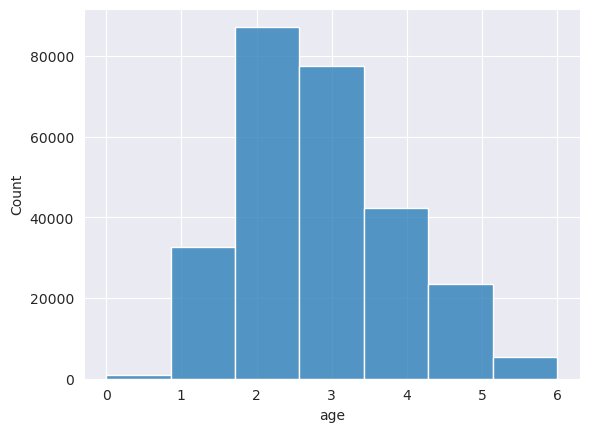

In [64]:
df = usr_targets.merge(usr_emb, how = 'inner', on = ['user_id'])
df = df[df['age'] != 'NA']
df = df.dropna()
df['age'] = df['age'].map(age_bucket)
sns.histplot(df['age'], bins = 7)

In [67]:
%%time
print(datetime.datetime.now())
x_train, x_test, y_train, y_test = train_test_split(\
    df.drop(['user_id', 'age', 'is_male'], axis = 1), df['age'], test_size = 0.33, random_state = SPLIT_SEED)

clf = CatBoostClassifier(iterations=5000, early_stopping_rounds=100)
#clf.fit(x_train, y_train, verbose = False)
clf.fit(x_train, y_train, verbose = True, eval_set=(x_test,y_test), use_best_model=True)
print(m.classification_report(y_test, clf.predict(x_test), \
                            target_names = ['<18', '18-25','25-34', '35-44', '45-54', '55-65', '65+']))

2023-02-24 20:09:43.136712
Learning rate set to 0.064784
0:	learn: 1.8938485	test: 1.8936584	best: 1.8936584 (0)	total: 338ms	remaining: 28m 8s
1:	learn: 1.8495533	test: 1.8493022	best: 1.8493022 (1)	total: 592ms	remaining: 24m 39s
2:	learn: 1.8095049	test: 1.8091566	best: 1.8091566 (2)	total: 850ms	remaining: 23m 36s
3:	learn: 1.7738181	test: 1.7734623	best: 1.7734623 (3)	total: 1.09s	remaining: 22m 48s
4:	learn: 1.7418953	test: 1.7414057	best: 1.7414057 (4)	total: 1.35s	remaining: 22m 30s
5:	learn: 1.7147231	test: 1.7140689	best: 1.7140689 (5)	total: 1.61s	remaining: 22m 19s
6:	learn: 1.6905715	test: 1.6898553	best: 1.6898553 (6)	total: 1.81s	remaining: 21m 34s
7:	learn: 1.6688276	test: 1.6680974	best: 1.6680974 (7)	total: 2.08s	remaining: 21m 35s
8:	learn: 1.6488111	test: 1.6481324	best: 1.6481324 (8)	total: 2.31s	remaining: 21m 19s
9:	learn: 1.6302548	test: 1.6295349	best: 1.6295349 (9)	total: 2.55s	remaining: 21m 12s
10:	learn: 1.6132955	test: 1.6125251	best: 1.6125251 (10)	total:

92:	learn: 1.3692250	test: 1.3750435	best: 1.3750435 (92)	total: 22.6s	remaining: 19m 50s
93:	learn: 1.3686987	test: 1.3745789	best: 1.3745789 (93)	total: 22.8s	remaining: 19m 50s
94:	learn: 1.3681962	test: 1.3742138	best: 1.3742138 (94)	total: 23.1s	remaining: 19m 52s
95:	learn: 1.3677864	test: 1.3738692	best: 1.3738692 (95)	total: 23.3s	remaining: 19m 50s
96:	learn: 1.3673425	test: 1.3734963	best: 1.3734963 (96)	total: 23.5s	remaining: 19m 49s
97:	learn: 1.3668521	test: 1.3730605	best: 1.3730605 (97)	total: 23.8s	remaining: 19m 49s
98:	learn: 1.3664216	test: 1.3727136	best: 1.3727136 (98)	total: 24s	remaining: 19m 50s
99:	learn: 1.3658050	test: 1.3721880	best: 1.3721880 (99)	total: 24.3s	remaining: 19m 49s
100:	learn: 1.3652844	test: 1.3717591	best: 1.3717591 (100)	total: 24.5s	remaining: 19m 49s
101:	learn: 1.3648299	test: 1.3714093	best: 1.3714093 (101)	total: 24.7s	remaining: 19m 47s
102:	learn: 1.3642470	test: 1.3709299	best: 1.3709299 (102)	total: 25s	remaining: 19m 47s
103:	lea

184:	learn: 1.3366197	test: 1.3505507	best: 1.3505507 (184)	total: 43.4s	remaining: 18m 49s
185:	learn: 1.3363827	test: 1.3504092	best: 1.3504092 (185)	total: 43.6s	remaining: 18m 49s
186:	learn: 1.3360889	test: 1.3501828	best: 1.3501828 (186)	total: 43.8s	remaining: 18m 48s
187:	learn: 1.3358155	test: 1.3499975	best: 1.3499975 (187)	total: 44.1s	remaining: 18m 47s
188:	learn: 1.3355500	test: 1.3498181	best: 1.3498181 (188)	total: 44.3s	remaining: 18m 46s
189:	learn: 1.3352906	test: 1.3496555	best: 1.3496555 (189)	total: 44.5s	remaining: 18m 46s
190:	learn: 1.3350437	test: 1.3494614	best: 1.3494614 (190)	total: 44.7s	remaining: 18m 44s
191:	learn: 1.3347539	test: 1.3492856	best: 1.3492856 (191)	total: 44.9s	remaining: 18m 44s
192:	learn: 1.3345222	test: 1.3491576	best: 1.3491576 (192)	total: 45.1s	remaining: 18m 43s
193:	learn: 1.3342169	test: 1.3489391	best: 1.3489391 (193)	total: 45.3s	remaining: 18m 42s
194:	learn: 1.3339129	test: 1.3487034	best: 1.3487034 (194)	total: 45.5s	remaini

274:	learn: 1.3155960	test: 1.3376526	best: 1.3376526 (274)	total: 1m 2s	remaining: 17m 52s
275:	learn: 1.3154180	test: 1.3375518	best: 1.3375518 (275)	total: 1m 2s	remaining: 17m 51s
276:	learn: 1.3152430	test: 1.3374595	best: 1.3374595 (276)	total: 1m 2s	remaining: 17m 51s
277:	learn: 1.3150439	test: 1.3373439	best: 1.3373439 (277)	total: 1m 3s	remaining: 17m 50s
278:	learn: 1.3148700	test: 1.3373003	best: 1.3373003 (278)	total: 1m 3s	remaining: 17m 50s
279:	learn: 1.3146577	test: 1.3372169	best: 1.3372169 (279)	total: 1m 3s	remaining: 17m 50s
280:	learn: 1.3144810	test: 1.3371151	best: 1.3371151 (280)	total: 1m 3s	remaining: 17m 49s
281:	learn: 1.3142942	test: 1.3370669	best: 1.3370669 (281)	total: 1m 3s	remaining: 17m 49s
282:	learn: 1.3141318	test: 1.3369849	best: 1.3369849 (282)	total: 1m 4s	remaining: 17m 48s
283:	learn: 1.3139544	test: 1.3369173	best: 1.3369173 (283)	total: 1m 4s	remaining: 17m 48s
284:	learn: 1.3137675	test: 1.3368386	best: 1.3368386 (284)	total: 1m 4s	remaini

363:	learn: 1.3008944	test: 1.3311515	best: 1.3311515 (363)	total: 1m 20s	remaining: 17m 10s
364:	learn: 1.3007412	test: 1.3311107	best: 1.3311107 (364)	total: 1m 21s	remaining: 17m 10s
365:	learn: 1.3004978	test: 1.3310112	best: 1.3310112 (365)	total: 1m 21s	remaining: 17m 9s
366:	learn: 1.3003327	test: 1.3309418	best: 1.3309418 (366)	total: 1m 21s	remaining: 17m 8s
367:	learn: 1.3002013	test: 1.3309015	best: 1.3309015 (367)	total: 1m 21s	remaining: 17m 8s
368:	learn: 1.3000683	test: 1.3308681	best: 1.3308681 (368)	total: 1m 21s	remaining: 17m 7s
369:	learn: 1.2999232	test: 1.3308087	best: 1.3308087 (369)	total: 1m 22s	remaining: 17m 7s
370:	learn: 1.2997652	test: 1.3307282	best: 1.3307282 (370)	total: 1m 22s	remaining: 17m 6s
371:	learn: 1.2996017	test: 1.3306660	best: 1.3306660 (371)	total: 1m 22s	remaining: 17m 6s
372:	learn: 1.2994544	test: 1.3306125	best: 1.3306125 (372)	total: 1m 22s	remaining: 17m 6s
373:	learn: 1.2993284	test: 1.3305596	best: 1.3305596 (373)	total: 1m 22s	rema

452:	learn: 1.2881759	test: 1.3265445	best: 1.3265445 (452)	total: 1m 39s	remaining: 16m 38s
453:	learn: 1.2880598	test: 1.3265126	best: 1.3265126 (453)	total: 1m 39s	remaining: 16m 37s
454:	learn: 1.2879573	test: 1.3264676	best: 1.3264676 (454)	total: 1m 39s	remaining: 16m 37s
455:	learn: 1.2878046	test: 1.3264210	best: 1.3264210 (455)	total: 1m 40s	remaining: 16m 36s
456:	learn: 1.2876507	test: 1.3263573	best: 1.3263573 (456)	total: 1m 40s	remaining: 16m 36s
457:	learn: 1.2875206	test: 1.3263038	best: 1.3263038 (457)	total: 1m 40s	remaining: 16m 35s
458:	learn: 1.2874211	test: 1.3262698	best: 1.3262698 (458)	total: 1m 40s	remaining: 16m 35s
459:	learn: 1.2872870	test: 1.3262195	best: 1.3262195 (459)	total: 1m 40s	remaining: 16m 35s
460:	learn: 1.2871690	test: 1.3261668	best: 1.3261668 (460)	total: 1m 41s	remaining: 16m 34s
461:	learn: 1.2870448	test: 1.3261424	best: 1.3261424 (461)	total: 1m 41s	remaining: 16m 34s
462:	learn: 1.2868384	test: 1.3260770	best: 1.3260770 (462)	total: 1m 

541:	learn: 1.2770659	test: 1.3231570	best: 1.3231567 (540)	total: 1m 58s	remaining: 16m 13s
542:	learn: 1.2769748	test: 1.3231413	best: 1.3231413 (542)	total: 1m 58s	remaining: 16m 13s
543:	learn: 1.2768698	test: 1.3231216	best: 1.3231216 (543)	total: 1m 58s	remaining: 16m 13s
544:	learn: 1.2767599	test: 1.3230990	best: 1.3230990 (544)	total: 1m 59s	remaining: 16m 13s
545:	learn: 1.2766123	test: 1.3230338	best: 1.3230338 (545)	total: 1m 59s	remaining: 16m 13s
546:	learn: 1.2764679	test: 1.3229908	best: 1.3229908 (546)	total: 1m 59s	remaining: 16m 13s
547:	learn: 1.2763446	test: 1.3229657	best: 1.3229657 (547)	total: 1m 59s	remaining: 16m 13s
548:	learn: 1.2762462	test: 1.3229632	best: 1.3229632 (548)	total: 2m	remaining: 16m 13s
549:	learn: 1.2761074	test: 1.3229145	best: 1.3229145 (549)	total: 2m	remaining: 16m 12s
550:	learn: 1.2760080	test: 1.3228850	best: 1.3228850 (550)	total: 2m	remaining: 16m 12s
551:	learn: 1.2758522	test: 1.3228219	best: 1.3228219 (551)	total: 2m	remaining: 1

631:	learn: 1.2670450	test: 1.3206711	best: 1.3206711 (631)	total: 2m 17s	remaining: 15m 49s
632:	learn: 1.2669413	test: 1.3206635	best: 1.3206635 (632)	total: 2m 17s	remaining: 15m 49s
633:	learn: 1.2668361	test: 1.3206598	best: 1.3206598 (633)	total: 2m 17s	remaining: 15m 48s
634:	learn: 1.2667034	test: 1.3206329	best: 1.3206329 (634)	total: 2m 17s	remaining: 15m 48s
635:	learn: 1.2666298	test: 1.3206212	best: 1.3206212 (635)	total: 2m 18s	remaining: 15m 47s
636:	learn: 1.2664821	test: 1.3205900	best: 1.3205900 (636)	total: 2m 18s	remaining: 15m 47s
637:	learn: 1.2663896	test: 1.3205667	best: 1.3205667 (637)	total: 2m 18s	remaining: 15m 47s
638:	learn: 1.2662151	test: 1.3205202	best: 1.3205202 (638)	total: 2m 18s	remaining: 15m 47s
639:	learn: 1.2661245	test: 1.3205116	best: 1.3205116 (639)	total: 2m 19s	remaining: 15m 47s
640:	learn: 1.2660194	test: 1.3204879	best: 1.3204879 (640)	total: 2m 19s	remaining: 15m 47s
641:	learn: 1.2658818	test: 1.3204649	best: 1.3204649 (641)	total: 2m 

721:	learn: 1.2575791	test: 1.3185705	best: 1.3185705 (721)	total: 2m 36s	remaining: 15m 29s
722:	learn: 1.2574408	test: 1.3185377	best: 1.3185377 (722)	total: 2m 37s	remaining: 15m 28s
723:	learn: 1.2572977	test: 1.3185035	best: 1.3185035 (723)	total: 2m 37s	remaining: 15m 28s
724:	learn: 1.2572158	test: 1.3184935	best: 1.3184935 (724)	total: 2m 37s	remaining: 15m 28s
725:	learn: 1.2570800	test: 1.3184712	best: 1.3184712 (725)	total: 2m 37s	remaining: 15m 28s
726:	learn: 1.2569784	test: 1.3184462	best: 1.3184462 (726)	total: 2m 37s	remaining: 15m 28s
727:	learn: 1.2568701	test: 1.3184199	best: 1.3184199 (727)	total: 2m 38s	remaining: 15m 27s
728:	learn: 1.2567484	test: 1.3184076	best: 1.3184076 (728)	total: 2m 38s	remaining: 15m 27s
729:	learn: 1.2566308	test: 1.3184045	best: 1.3184045 (729)	total: 2m 38s	remaining: 15m 27s
730:	learn: 1.2565277	test: 1.3183727	best: 1.3183727 (730)	total: 2m 38s	remaining: 15m 27s
731:	learn: 1.2564325	test: 1.3183564	best: 1.3183564 (731)	total: 2m 

810:	learn: 1.2485420	test: 1.3170519	best: 1.3170519 (810)	total: 2m 56s	remaining: 15m 9s
811:	learn: 1.2484494	test: 1.3170337	best: 1.3170337 (811)	total: 2m 56s	remaining: 15m 9s
812:	learn: 1.2483399	test: 1.3170223	best: 1.3170223 (812)	total: 2m 56s	remaining: 15m 8s
813:	learn: 1.2482384	test: 1.3170091	best: 1.3170091 (813)	total: 2m 56s	remaining: 15m 8s
814:	learn: 1.2481401	test: 1.3169959	best: 1.3169959 (814)	total: 2m 56s	remaining: 15m 8s
815:	learn: 1.2480544	test: 1.3169794	best: 1.3169794 (815)	total: 2m 57s	remaining: 15m 8s
816:	learn: 1.2479732	test: 1.3169575	best: 1.3169575 (816)	total: 2m 57s	remaining: 15m 7s
817:	learn: 1.2478769	test: 1.3169463	best: 1.3169463 (817)	total: 2m 57s	remaining: 15m 7s
818:	learn: 1.2477603	test: 1.3169180	best: 1.3169180 (818)	total: 2m 57s	remaining: 15m 7s
819:	learn: 1.2476771	test: 1.3168986	best: 1.3168986 (819)	total: 2m 57s	remaining: 15m 7s
820:	learn: 1.2475867	test: 1.3168997	best: 1.3168986 (819)	total: 2m 58s	remain

901:	learn: 1.2399833	test: 1.3157850	best: 1.3157850 (901)	total: 3m 15s	remaining: 14m 48s
902:	learn: 1.2398883	test: 1.3157706	best: 1.3157706 (902)	total: 3m 15s	remaining: 14m 48s
903:	learn: 1.2397747	test: 1.3157659	best: 1.3157659 (903)	total: 3m 16s	remaining: 14m 48s
904:	learn: 1.2396504	test: 1.3157424	best: 1.3157424 (904)	total: 3m 16s	remaining: 14m 48s
905:	learn: 1.2395712	test: 1.3157270	best: 1.3157270 (905)	total: 3m 16s	remaining: 14m 47s
906:	learn: 1.2394928	test: 1.3157278	best: 1.3157270 (905)	total: 3m 16s	remaining: 14m 47s
907:	learn: 1.2394054	test: 1.3157257	best: 1.3157257 (907)	total: 3m 16s	remaining: 14m 47s
908:	learn: 1.2392885	test: 1.3157192	best: 1.3157192 (908)	total: 3m 17s	remaining: 14m 47s
909:	learn: 1.2392051	test: 1.3157036	best: 1.3157036 (909)	total: 3m 17s	remaining: 14m 47s
910:	learn: 1.2390936	test: 1.3156720	best: 1.3156720 (910)	total: 3m 17s	remaining: 14m 47s
911:	learn: 1.2389776	test: 1.3156565	best: 1.3156565 (911)	total: 3m 

990:	learn: 1.2316472	test: 1.3145483	best: 1.3145483 (990)	total: 3m 34s	remaining: 14m 28s
991:	learn: 1.2316010	test: 1.3145509	best: 1.3145483 (990)	total: 3m 34s	remaining: 14m 28s
992:	learn: 1.2315306	test: 1.3145467	best: 1.3145467 (992)	total: 3m 35s	remaining: 14m 27s
993:	learn: 1.2313863	test: 1.3145228	best: 1.3145228 (993)	total: 3m 35s	remaining: 14m 27s
994:	learn: 1.2312555	test: 1.3144920	best: 1.3144920 (994)	total: 3m 35s	remaining: 14m 27s
995:	learn: 1.2311957	test: 1.3144837	best: 1.3144837 (995)	total: 3m 35s	remaining: 14m 27s
996:	learn: 1.2311180	test: 1.3144799	best: 1.3144799 (996)	total: 3m 35s	remaining: 14m 27s
997:	learn: 1.2310162	test: 1.3144617	best: 1.3144617 (997)	total: 3m 36s	remaining: 14m 26s
998:	learn: 1.2309358	test: 1.3144643	best: 1.3144617 (997)	total: 3m 36s	remaining: 14m 26s
999:	learn: 1.2308578	test: 1.3144713	best: 1.3144617 (997)	total: 3m 36s	remaining: 14m 26s
1000:	learn: 1.2307784	test: 1.3144601	best: 1.3144601 (1000)	total: 3

1077:	learn: 1.2240601	test: 1.3137144	best: 1.3137139 (1076)	total: 3m 52s	remaining: 14m 7s
1078:	learn: 1.2239745	test: 1.3137061	best: 1.3137061 (1078)	total: 3m 53s	remaining: 14m 6s
1079:	learn: 1.2238374	test: 1.3136706	best: 1.3136706 (1079)	total: 3m 53s	remaining: 14m 6s
1080:	learn: 1.2237546	test: 1.3136678	best: 1.3136678 (1080)	total: 3m 53s	remaining: 14m 6s
1081:	learn: 1.2236942	test: 1.3136709	best: 1.3136678 (1080)	total: 3m 53s	remaining: 14m 6s
1082:	learn: 1.2235947	test: 1.3136631	best: 1.3136631 (1082)	total: 3m 53s	remaining: 14m 6s
1083:	learn: 1.2235294	test: 1.3136676	best: 1.3136631 (1082)	total: 3m 54s	remaining: 14m 5s
1084:	learn: 1.2234088	test: 1.3136651	best: 1.3136631 (1082)	total: 3m 54s	remaining: 14m 5s
1085:	learn: 1.2233244	test: 1.3136603	best: 1.3136603 (1085)	total: 3m 54s	remaining: 14m 5s
1086:	learn: 1.2232511	test: 1.3136726	best: 1.3136603 (1085)	total: 3m 54s	remaining: 14m 5s
1087:	learn: 1.2231374	test: 1.3136496	best: 1.3136496 (1087

1165:	learn: 1.2163020	test: 1.3129813	best: 1.3129813 (1165)	total: 4m 11s	remaining: 13m 48s
1166:	learn: 1.2162163	test: 1.3129700	best: 1.3129700 (1166)	total: 4m 12s	remaining: 13m 48s
1167:	learn: 1.2161101	test: 1.3129595	best: 1.3129595 (1167)	total: 4m 12s	remaining: 13m 47s
1168:	learn: 1.2160278	test: 1.3129526	best: 1.3129526 (1168)	total: 4m 12s	remaining: 13m 47s
1169:	learn: 1.2159359	test: 1.3129521	best: 1.3129521 (1169)	total: 4m 12s	remaining: 13m 47s
1170:	learn: 1.2158475	test: 1.3129553	best: 1.3129521 (1169)	total: 4m 12s	remaining: 13m 47s
1171:	learn: 1.2157652	test: 1.3129553	best: 1.3129521 (1169)	total: 4m 13s	remaining: 13m 46s
1172:	learn: 1.2156648	test: 1.3129343	best: 1.3129343 (1172)	total: 4m 13s	remaining: 13m 46s
1173:	learn: 1.2155841	test: 1.3129215	best: 1.3129215 (1173)	total: 4m 13s	remaining: 13m 46s
1174:	learn: 1.2154973	test: 1.3129151	best: 1.3129151 (1174)	total: 4m 13s	remaining: 13m 46s
1175:	learn: 1.2153951	test: 1.3129064	best: 1.312

1253:	learn: 1.2088084	test: 1.3123080	best: 1.3123080 (1253)	total: 4m 30s	remaining: 13m 28s
1254:	learn: 1.2087429	test: 1.3122921	best: 1.3122921 (1254)	total: 4m 30s	remaining: 13m 28s
1255:	learn: 1.2086484	test: 1.3122905	best: 1.3122905 (1255)	total: 4m 31s	remaining: 13m 28s
1256:	learn: 1.2085540	test: 1.3122613	best: 1.3122613 (1256)	total: 4m 31s	remaining: 13m 28s
1257:	learn: 1.2084887	test: 1.3122547	best: 1.3122547 (1257)	total: 4m 31s	remaining: 13m 27s
1258:	learn: 1.2083972	test: 1.3122577	best: 1.3122547 (1257)	total: 4m 31s	remaining: 13m 27s
1259:	learn: 1.2083278	test: 1.3122584	best: 1.3122547 (1257)	total: 4m 31s	remaining: 13m 27s
1260:	learn: 1.2082699	test: 1.3122563	best: 1.3122547 (1257)	total: 4m 32s	remaining: 13m 26s
1261:	learn: 1.2082056	test: 1.3122540	best: 1.3122540 (1261)	total: 4m 32s	remaining: 13m 26s
1262:	learn: 1.2081181	test: 1.3122524	best: 1.3122524 (1262)	total: 4m 32s	remaining: 13m 26s
1263:	learn: 1.2080409	test: 1.3122499	best: 1.312

1340:	learn: 1.2014367	test: 1.3117549	best: 1.3117549 (1340)	total: 4m 49s	remaining: 13m 8s
1341:	learn: 1.2013687	test: 1.3117493	best: 1.3117493 (1341)	total: 4m 49s	remaining: 13m 8s
1342:	learn: 1.2013102	test: 1.3117367	best: 1.3117367 (1342)	total: 4m 49s	remaining: 13m 8s
1343:	learn: 1.2012421	test: 1.3117440	best: 1.3117367 (1342)	total: 4m 49s	remaining: 13m 8s
1344:	learn: 1.2011632	test: 1.3117458	best: 1.3117367 (1342)	total: 4m 49s	remaining: 13m 7s
1345:	learn: 1.2011049	test: 1.3117434	best: 1.3117367 (1342)	total: 4m 50s	remaining: 13m 7s
1346:	learn: 1.2010143	test: 1.3117250	best: 1.3117250 (1346)	total: 4m 50s	remaining: 13m 7s
1347:	learn: 1.2009476	test: 1.3117180	best: 1.3117180 (1347)	total: 4m 50s	remaining: 13m 6s
1348:	learn: 1.2008552	test: 1.3117143	best: 1.3117143 (1348)	total: 4m 50s	remaining: 13m 6s
1349:	learn: 1.2007965	test: 1.3117129	best: 1.3117129 (1349)	total: 4m 50s	remaining: 13m 6s
1350:	learn: 1.2007022	test: 1.3117045	best: 1.3117045 (1350

1428:	learn: 1.1945690	test: 1.3112423	best: 1.3112423 (1428)	total: 5m 7s	remaining: 12m 48s
1429:	learn: 1.1944950	test: 1.3112481	best: 1.3112423 (1428)	total: 5m 7s	remaining: 12m 48s
1430:	learn: 1.1944311	test: 1.3112534	best: 1.3112423 (1428)	total: 5m 8s	remaining: 12m 48s
1431:	learn: 1.1943492	test: 1.3112545	best: 1.3112423 (1428)	total: 5m 8s	remaining: 12m 48s
1432:	learn: 1.1942873	test: 1.3112463	best: 1.3112423 (1428)	total: 5m 8s	remaining: 12m 47s
1433:	learn: 1.1941988	test: 1.3112462	best: 1.3112423 (1428)	total: 5m 8s	remaining: 12m 47s
1434:	learn: 1.1941382	test: 1.3112470	best: 1.3112423 (1428)	total: 5m 8s	remaining: 12m 47s
1435:	learn: 1.1940946	test: 1.3112488	best: 1.3112423 (1428)	total: 5m 9s	remaining: 12m 47s
1436:	learn: 1.1940380	test: 1.3112546	best: 1.3112423 (1428)	total: 5m 9s	remaining: 12m 47s
1437:	learn: 1.1939718	test: 1.3112466	best: 1.3112423 (1428)	total: 5m 9s	remaining: 12m 46s
1438:	learn: 1.1939026	test: 1.3112432	best: 1.3112423 (1428

1515:	learn: 1.1877742	test: 1.3107644	best: 1.3107643 (1514)	total: 5m 26s	remaining: 12m 29s
1516:	learn: 1.1877045	test: 1.3107606	best: 1.3107606 (1516)	total: 5m 26s	remaining: 12m 29s
1517:	learn: 1.1876079	test: 1.3107537	best: 1.3107537 (1517)	total: 5m 26s	remaining: 12m 29s
1518:	learn: 1.1875478	test: 1.3107557	best: 1.3107537 (1517)	total: 5m 26s	remaining: 12m 29s
1519:	learn: 1.1874604	test: 1.3107500	best: 1.3107500 (1519)	total: 5m 27s	remaining: 12m 28s
1520:	learn: 1.1873742	test: 1.3107599	best: 1.3107500 (1519)	total: 5m 27s	remaining: 12m 28s
1521:	learn: 1.1872968	test: 1.3107735	best: 1.3107500 (1519)	total: 5m 27s	remaining: 12m 28s
1522:	learn: 1.1872079	test: 1.3107687	best: 1.3107500 (1519)	total: 5m 27s	remaining: 12m 28s
1523:	learn: 1.1871266	test: 1.3107659	best: 1.3107500 (1519)	total: 5m 28s	remaining: 12m 28s
1524:	learn: 1.1870276	test: 1.3107576	best: 1.3107500 (1519)	total: 5m 28s	remaining: 12m 27s
1525:	learn: 1.1869450	test: 1.3107606	best: 1.310

1602:	learn: 1.1809345	test: 1.3104269	best: 1.3104008 (1596)	total: 5m 44s	remaining: 12m 10s
1603:	learn: 1.1808595	test: 1.3104134	best: 1.3104008 (1596)	total: 5m 44s	remaining: 12m 10s
1604:	learn: 1.1807793	test: 1.3104082	best: 1.3104008 (1596)	total: 5m 45s	remaining: 12m 10s
1605:	learn: 1.1806806	test: 1.3104054	best: 1.3104008 (1596)	total: 5m 45s	remaining: 12m 9s
1606:	learn: 1.1805960	test: 1.3103921	best: 1.3103921 (1606)	total: 5m 45s	remaining: 12m 9s
1607:	learn: 1.1805319	test: 1.3103819	best: 1.3103819 (1607)	total: 5m 45s	remaining: 12m 9s
1608:	learn: 1.1804573	test: 1.3103716	best: 1.3103716 (1608)	total: 5m 45s	remaining: 12m 9s
1609:	learn: 1.1803595	test: 1.3103749	best: 1.3103716 (1608)	total: 5m 46s	remaining: 12m 8s
1610:	learn: 1.1802526	test: 1.3103528	best: 1.3103528 (1610)	total: 5m 46s	remaining: 12m 8s
1611:	learn: 1.1801645	test: 1.3103544	best: 1.3103528 (1610)	total: 5m 46s	remaining: 12m 8s
1612:	learn: 1.1800951	test: 1.3103516	best: 1.3103516 (1

1690:	learn: 1.1741936	test: 1.3100343	best: 1.3100343 (1690)	total: 6m 3s	remaining: 11m 50s
1691:	learn: 1.1741242	test: 1.3100385	best: 1.3100343 (1690)	total: 6m 3s	remaining: 11m 50s
1692:	learn: 1.1740422	test: 1.3100319	best: 1.3100319 (1692)	total: 6m 3s	remaining: 11m 50s
1693:	learn: 1.1739661	test: 1.3100355	best: 1.3100319 (1692)	total: 6m 3s	remaining: 11m 50s
1694:	learn: 1.1739017	test: 1.3100432	best: 1.3100319 (1692)	total: 6m 4s	remaining: 11m 49s
1695:	learn: 1.1738099	test: 1.3100433	best: 1.3100319 (1692)	total: 6m 4s	remaining: 11m 49s
1696:	learn: 1.1737387	test: 1.3100415	best: 1.3100319 (1692)	total: 6m 4s	remaining: 11m 49s
1697:	learn: 1.1736777	test: 1.3100299	best: 1.3100299 (1697)	total: 6m 4s	remaining: 11m 49s
1698:	learn: 1.1736051	test: 1.3100345	best: 1.3100299 (1697)	total: 6m 4s	remaining: 11m 48s
1699:	learn: 1.1735457	test: 1.3100237	best: 1.3100237 (1699)	total: 6m 5s	remaining: 11m 48s
1700:	learn: 1.1734912	test: 1.3100210	best: 1.3100210 (1700

1777:	learn: 1.1676684	test: 1.3098625	best: 1.3098278 (1762)	total: 6m 21s	remaining: 11m 31s
1778:	learn: 1.1675562	test: 1.3098535	best: 1.3098278 (1762)	total: 6m 21s	remaining: 11m 31s
1779:	learn: 1.1674578	test: 1.3098325	best: 1.3098278 (1762)	total: 6m 22s	remaining: 11m 31s
1780:	learn: 1.1673678	test: 1.3098351	best: 1.3098278 (1762)	total: 6m 22s	remaining: 11m 31s
1781:	learn: 1.1673022	test: 1.3098395	best: 1.3098278 (1762)	total: 6m 22s	remaining: 11m 30s
1782:	learn: 1.1672640	test: 1.3098436	best: 1.3098278 (1762)	total: 6m 22s	remaining: 11m 30s
1783:	learn: 1.1671914	test: 1.3098341	best: 1.3098278 (1762)	total: 6m 23s	remaining: 11m 30s
1784:	learn: 1.1671096	test: 1.3098242	best: 1.3098242 (1784)	total: 6m 23s	remaining: 11m 30s
1785:	learn: 1.1670264	test: 1.3098252	best: 1.3098242 (1784)	total: 6m 23s	remaining: 11m 29s
1786:	learn: 1.1669655	test: 1.3098184	best: 1.3098184 (1786)	total: 6m 23s	remaining: 11m 29s
1787:	learn: 1.1668778	test: 1.3098128	best: 1.309

1864:	learn: 1.1612705	test: 1.3096101	best: 1.3096101 (1864)	total: 6m 40s	remaining: 11m 12s
1865:	learn: 1.1611905	test: 1.3095878	best: 1.3095878 (1865)	total: 6m 40s	remaining: 11m 12s
1866:	learn: 1.1611181	test: 1.3095831	best: 1.3095831 (1866)	total: 6m 40s	remaining: 11m 12s
1867:	learn: 1.1610028	test: 1.3095861	best: 1.3095831 (1866)	total: 6m 41s	remaining: 11m 12s
1868:	learn: 1.1609308	test: 1.3095892	best: 1.3095831 (1866)	total: 6m 41s	remaining: 11m 12s
1869:	learn: 1.1608486	test: 1.3095891	best: 1.3095831 (1866)	total: 6m 41s	remaining: 11m 11s
1870:	learn: 1.1607801	test: 1.3095813	best: 1.3095813 (1870)	total: 6m 41s	remaining: 11m 11s
1871:	learn: 1.1607069	test: 1.3095806	best: 1.3095806 (1871)	total: 6m 41s	remaining: 11m 11s
1872:	learn: 1.1606429	test: 1.3095623	best: 1.3095623 (1872)	total: 6m 42s	remaining: 11m 11s
1873:	learn: 1.1605694	test: 1.3095603	best: 1.3095603 (1873)	total: 6m 42s	remaining: 11m 11s
1874:	learn: 1.1605139	test: 1.3095637	best: 1.309

1951:	learn: 1.1548786	test: 1.3095150	best: 1.3095150 (1951)	total: 6m 58s	remaining: 10m 54s
1952:	learn: 1.1548114	test: 1.3095092	best: 1.3095092 (1952)	total: 6m 59s	remaining: 10m 53s
1953:	learn: 1.1547493	test: 1.3095258	best: 1.3095092 (1952)	total: 6m 59s	remaining: 10m 53s
1954:	learn: 1.1546745	test: 1.3095191	best: 1.3095092 (1952)	total: 6m 59s	remaining: 10m 53s
1955:	learn: 1.1546092	test: 1.3095142	best: 1.3095092 (1952)	total: 6m 59s	remaining: 10m 53s
1956:	learn: 1.1545268	test: 1.3095022	best: 1.3095022 (1956)	total: 7m	remaining: 10m 53s
1957:	learn: 1.1544682	test: 1.3095126	best: 1.3095022 (1956)	total: 7m	remaining: 10m 53s
1958:	learn: 1.1544107	test: 1.3095074	best: 1.3095022 (1956)	total: 7m	remaining: 10m 52s
1959:	learn: 1.1543321	test: 1.3094865	best: 1.3094865 (1959)	total: 7m	remaining: 10m 52s
1960:	learn: 1.1542508	test: 1.3094911	best: 1.3094865 (1959)	total: 7m 1s	remaining: 10m 52s
1961:	learn: 1.1541752	test: 1.3094949	best: 1.3094865 (1959)	total

2038:	learn: 1.1484612	test: 1.3093616	best: 1.3093485 (2034)	total: 7m 18s	remaining: 10m 36s
2039:	learn: 1.1483835	test: 1.3093598	best: 1.3093485 (2034)	total: 7m 18s	remaining: 10m 36s
2040:	learn: 1.1482872	test: 1.3093478	best: 1.3093478 (2040)	total: 7m 18s	remaining: 10m 35s
2041:	learn: 1.1482221	test: 1.3093529	best: 1.3093478 (2040)	total: 7m 18s	remaining: 10m 35s
2042:	learn: 1.1481335	test: 1.3093483	best: 1.3093478 (2040)	total: 7m 19s	remaining: 10m 35s
2043:	learn: 1.1480669	test: 1.3093478	best: 1.3093478 (2043)	total: 7m 19s	remaining: 10m 35s
2044:	learn: 1.1479851	test: 1.3093458	best: 1.3093458 (2044)	total: 7m 19s	remaining: 10m 34s
2045:	learn: 1.1479132	test: 1.3093372	best: 1.3093372 (2045)	total: 7m 19s	remaining: 10m 34s
2046:	learn: 1.1478451	test: 1.3093389	best: 1.3093372 (2045)	total: 7m 19s	remaining: 10m 34s
2047:	learn: 1.1477677	test: 1.3093361	best: 1.3093361 (2047)	total: 7m 20s	remaining: 10m 34s
2048:	learn: 1.1476916	test: 1.3093419	best: 1.309

2125:	learn: 1.1421813	test: 1.3091946	best: 1.3091903 (2124)	total: 7m 36s	remaining: 10m 16s
2126:	learn: 1.1421251	test: 1.3091866	best: 1.3091866 (2126)	total: 7m 36s	remaining: 10m 16s
2127:	learn: 1.1420669	test: 1.3091836	best: 1.3091836 (2127)	total: 7m 36s	remaining: 10m 16s
2128:	learn: 1.1419906	test: 1.3091788	best: 1.3091788 (2128)	total: 7m 37s	remaining: 10m 16s
2129:	learn: 1.1419269	test: 1.3091808	best: 1.3091788 (2128)	total: 7m 37s	remaining: 10m 16s
2130:	learn: 1.1418411	test: 1.3091798	best: 1.3091788 (2128)	total: 7m 37s	remaining: 10m 15s
2131:	learn: 1.1417795	test: 1.3091813	best: 1.3091788 (2128)	total: 7m 37s	remaining: 10m 15s
2132:	learn: 1.1417066	test: 1.3091625	best: 1.3091625 (2132)	total: 7m 37s	remaining: 10m 15s
2133:	learn: 1.1416423	test: 1.3091517	best: 1.3091517 (2133)	total: 7m 38s	remaining: 10m 15s
2134:	learn: 1.1415645	test: 1.3091613	best: 1.3091517 (2133)	total: 7m 38s	remaining: 10m 15s
2135:	learn: 1.1414735	test: 1.3091700	best: 1.309

2212:	learn: 1.1361236	test: 1.3091200	best: 1.3090846 (2193)	total: 7m 54s	remaining: 9m 58s
2213:	learn: 1.1360642	test: 1.3091253	best: 1.3090846 (2193)	total: 7m 55s	remaining: 9m 57s
2214:	learn: 1.1360149	test: 1.3091281	best: 1.3090846 (2193)	total: 7m 55s	remaining: 9m 57s
2215:	learn: 1.1359599	test: 1.3091208	best: 1.3090846 (2193)	total: 7m 55s	remaining: 9m 57s
2216:	learn: 1.1359086	test: 1.3091136	best: 1.3090846 (2193)	total: 7m 55s	remaining: 9m 57s
2217:	learn: 1.1358533	test: 1.3091153	best: 1.3090846 (2193)	total: 7m 55s	remaining: 9m 56s
2218:	learn: 1.1357617	test: 1.3091071	best: 1.3090846 (2193)	total: 7m 56s	remaining: 9m 56s
2219:	learn: 1.1356995	test: 1.3091096	best: 1.3090846 (2193)	total: 7m 56s	remaining: 9m 56s
2220:	learn: 1.1355994	test: 1.3091239	best: 1.3090846 (2193)	total: 7m 56s	remaining: 9m 56s
2221:	learn: 1.1355361	test: 1.3091112	best: 1.3090846 (2193)	total: 7m 56s	remaining: 9m 56s
2222:	learn: 1.1354844	test: 1.3091101	best: 1.3090846 (2193

2300:	learn: 1.1300844	test: 1.3091858	best: 1.3090707 (2241)	total: 8m 13s	remaining: 9m 38s
2301:	learn: 1.1299906	test: 1.3091848	best: 1.3090707 (2241)	total: 8m 13s	remaining: 9m 38s
2302:	learn: 1.1299075	test: 1.3091967	best: 1.3090707 (2241)	total: 8m 14s	remaining: 9m 38s
2303:	learn: 1.1298218	test: 1.3091842	best: 1.3090707 (2241)	total: 8m 14s	remaining: 9m 38s
2304:	learn: 1.1297404	test: 1.3092028	best: 1.3090707 (2241)	total: 8m 14s	remaining: 9m 38s
2305:	learn: 1.1296571	test: 1.3092073	best: 1.3090707 (2241)	total: 8m 14s	remaining: 9m 37s
2306:	learn: 1.1295865	test: 1.3092084	best: 1.3090707 (2241)	total: 8m 14s	remaining: 9m 37s
2307:	learn: 1.1295164	test: 1.3091974	best: 1.3090707 (2241)	total: 8m 15s	remaining: 9m 37s
2308:	learn: 1.1294683	test: 1.3091910	best: 1.3090707 (2241)	total: 8m 15s	remaining: 9m 37s
2309:	learn: 1.1293799	test: 1.3091927	best: 1.3090707 (2241)	total: 8m 15s	remaining: 9m 37s
2310:	learn: 1.1293100	test: 1.3091947	best: 1.3090707 (2241

f1 0.00 0.40 0.54 0.45 0.27 0.28 0.03 - 0.44 0.28 0.42 (als = 250.30 without)

In [68]:
clf.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'MultiClass',
 'iterations': 5000,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'od_pval': 0,
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'od_type': 'Iter',
 'rsm': 1,
 'boost_from_average': False,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'use_best_model': True,
 'od_wait': 100,
 'class_names': [0, 1, 2, 3, 4, 5, 6],
 'random_seed': 0,
 'depth': 6,
 'posterior_sampling': False,
 'border_count': 254,
 'bagging_temperature': 1,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'MultiClass',
 'learning_rate': 0.064

In [32]:
%%time
print(datetime.datetime.now())
clf.fit(df.drop(['user_id', 'age', 'is_male'], axis = 1), df['age'], verbose = False)
id_to_submit['age'] = clf.predict(id_to_submit[['user_id']].merge(usr_emb, how = 'inner', on = ['user_id']))

2023-02-24 18:44:35.844592
CPU times: user 35min 37s, sys: 11.3 s, total: 35min 49s
Wall time: 4min 48s


In [33]:
df.shape

(269957, 120)

## Сабмит

In [325]:
id_to_submit.head()

,user_id,is_male,age
221301,221301,0.982212,2
31271,31271,0.531357,3
211594,211594,0.591643,2
253119,253119,0.451730,2
192578,192578,0.867459,2


In [347]:
id_to_submit.to_csv(f'{LOCAL_DATA_PATH}/submission14.csv', index = False)

In [348]:
! head $LOCAL_DATA_PATH/submission1.csv

user_id,is_male,age
221301,0.9523721503994212,2
31271,0.540058202285835,3
211594,0.4921148361193288,2
253119,0.5031936669434278,2
192578,0.7343094598406392,2
268458,0.28223318330597313,2
205507,0.5256998725263032,3
341343,0.6329608219845485,3
282144,0.026135216529779966,2


# Скор на лидерборде

In [187]:
#context_scorer(submission, answers)

In [339]:
xx=clf.get_feature_importance(prettified=True)

In [340]:
xx.head(50)

,Feature Id,Importances
0,1347,1.448866
1,1753,1.367869
2,19,1.241388
3,1235,1.207978
4,886,1.049608
5,300,1.006760
6,664,0.930509
7,1767,0.897595
8,776,0.884337
9,614,0.857959
